# Heavy User Cutoffs - No Search Counts

Based on analysis done by Brendan Colloran from the Strategy and Insights team in 2016, Saptarshi Guha in 2017 and Project Ahab in 2018, I will be looking at URI count, search count, subsession hours and active hours.

I'm looking at data from a week in September as a baseline since that avoids summer and major holidays.

I'm reading the Firefox data from main_summary.  I could use clients_daily instead of adding up a day's worth of pings from main_summary.  The advantage to this would be that I wouldn't have to create the work of clients_daily.  The downside is that I've spent most of my time analyzing main_summary data so I'm more familiar with it, and I've noticed some high values for active_hours in clients_daily that I can't account for from the pings in main_summary.  My analysis of the difference between main_summary and clients_daily is in this notebook: <a href="https://dbc-caf9527b-e073.cloud.databricks.com/#notebook/72034/command/72063">Main Summary vs Clients Daily</a>

In [3]:
import pyspark.sql.functions as F
import pyspark.sql.types as st
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

###Prepare Data

In [5]:
#Global variables
sample_id = 42
week_1_start = '20180920'
week_1_end = '20180926'
week_4_end = '20181017'
thday = '20180920'
fday = '20180921'
saday = '20180922'
sday = '20180923'
mday = '20180924'
tday = '20180925'
wday = '20180926'
sday_cond = "submission_date_s3 = \'" +  sday + "\'"
mday_cond = "submission_date_s3 = \'" +  mday + "\'"
tday_cond = "submission_date_s3 = \'" +  tday + "\'"
wday_cond = "submission_date_s3 = \'" +  wday + "\'"
thday_cond = "submission_date_s3 = \'" +  thday + "\'"
fday_cond = "submission_date_s3 = \'" +  fday + "\'"
saday_cond = "submission_date_s3 = \'" +  saday + "\'"
prob = (0.5, 0.75, 0.80, 0.90, 0.95, 0.96, 0.97, 0.975, 0.98, 0.99, 0.995)
relError = 0
percentiles = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1.0]
bp_day_lbls = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']
bp_seg_lbls = ['Day All', 'Day No Zeros', 'Day No Zeros No Ex', 'Day aDAU', 'Week Avg All', 'Week Avg No Zeros', 
             'Week Avg No Zeros No Ex', 'Week Avg aDAU', '4 Week Avg aDAU']

Active ticks are in 5 second increments, so it is converted to hours. Subsession length is in seconds, so it is converted to hours. In looking at the difference between active_ticks and scalar_parent_browser_engagement_active_ticks, they are the same values except where active_ticks has a number scalar_parent_browser_engagement_active_ticks is often null.

Calculate the values for the day from pings the same way the clients_daily value determines them - sum, mean, max, first, count.

For search counts, per Ben's suggestion, using search_clients_daily. "For total searches, you can use sap for "searches issued from Mozilla's UI", and organic for "searches made in content" (i.e. from google.com's ui)"

In [7]:
ping_query = """
    SELECT
        client_id,
        submission_date_s3,
        coalesce(scalar_parent_browser_engagement_total_uri_count, 0) AS uri_count,
        coalesce(scalar_parent_browser_engagement_active_ticks, 0) AS active_ticks,
        (coalesce(scalar_parent_browser_engagement_active_ticks, 0))*5/3600 AS active_hours,        
        subsession_length,
        (subsession_length/3600) AS subsession_hours,
        session_length,
        profile_subsession_counter,
        subsession_counter,
        session_start_date,
        subsession_start_date,
        reason,
        active_addons_count,
        scalar_parent_browser_engagement_max_concurrent_tab_count AS tab_count,
        scalar_parent_browser_engagement_max_concurrent_window_count AS window_count,
        scalar_parent_browser_engagement_unique_domains_count AS domains_count,
        profile_creation_date,
        profile_reset_date,
        previous_build_id,
        normalized_channel,
        os,
        normalized_os_version,
        windows_build_number,
        install_year,
        creation_date,
        distribution_id,
        submission_date,
        app_build_id,
        app_display_version,
        update_channel,
        update_enabled,
        update_auto_download,
        timezone_offset,
        vendor,
        is_default_browser,
        default_search_engine,
        devtools_toolbox_opened_count,
        client_submission_date,
        places_bookmarks_count,
        places_pages_count,
        scalar_parent_browser_engagement_tab_open_event_count AS tab_event_count,
        scalar_parent_browser_engagement_window_open_event_count AS window_event_count,
        scalar_parent_browser_errors_collected_count AS errors_collected_count,
        scalar_parent_devtools_current_theme AS current_theme,
        scalar_parent_formautofill_availability AS formautofill_availability, 
        country,
        city,
        geo_subdivision1,
        locale,
        antivirus,
        antispyware,
        firewall,
        session_id,
        subsession_id,
        sync_configured,
        sync_count_desktop,
        sync_count_mobile,
        disabled_addons_ids,
        active_theme,
        user_prefs,
        experiments,
        sample_id,
        document_id
    FROM main_summary
    WHERE 
      app_name='Firefox'
      AND submission_date_s3 >= '{}'
      AND submission_date_s3 <= '{}'
      AND sample_id = '{}'
    ORDER BY
        client_id,
        submission_date_s3,
        profile_subsession_counter
    """

# From telemetry docs for how clients_daily deteremines values
sum_query = """
    SELECT 
      client_id,
      submission_date_s3,
      sum(coalesce(scalar_parent_browser_engagement_total_uri_count, 0)) AS td_uri,
      sum(coalesce(scalar_parent_browser_engagement_active_ticks, 0)) AS td_active_ticks,      
      sum(coalesce(scalar_parent_browser_engagement_active_ticks, 0)*5/3600) AS td_active_hours,
      sum(subsession_length/3600) AS td_subsession_hours,   
      sum(CASE WHEN subsession_counter = 1 THEN 1 ELSE 0 END) AS sessions_started_on_this_day,
      mean(active_addons_count) AS active_addons_count_mean,
      max(scalar_parent_browser_engagement_max_concurrent_tab_count) AS tab_count_max,
      max(scalar_parent_browser_engagement_max_concurrent_window_count) AS window_count_max,
      max(scalar_parent_browser_engagement_unique_domains_count) AS domains_count_max,
      first(profile_creation_date) AS profile_creation_date,
      first(previous_build_id) AS previous_build_id,
      first(normalized_channel) AS normalized_channel,
      first(os) AS os,
      first(normalized_os_version) AS normalized_os_version,
      first(windows_build_number) AS windows_build_number,
      first(install_year) AS install_year,
      first(distribution_id) AS distribution_id,
      count(distinct document_id) AS pings_aggregated_by_this_row,
      first(app_build_id) AS app_build_id,
      first(app_display_version) AS app_display_version,
      first(update_channel) AS update_channel,
      first(update_enabled) AS update_enabled,
      first(update_auto_download) AS update_auto_download,
      first(timezone_offset) AS timezone_offset,
      first(vendor) AS vendor,
      first(is_default_browser) AS is_default_browser,
      first(default_search_engine) AS default_search_engine,
      sum(devtools_toolbox_opened_count) AS devtools_toolbox_opened_count_sum,
      mean(places_bookmarks_count) AS places_bookmarks_count_mean,
      mean(places_pages_count) AS places_pages_count_mean,
      sum(scalar_parent_browser_engagement_tab_open_event_count) AS td_tab_event_count,
      sum(scalar_parent_browser_engagement_window_open_event_count) AS td_window_event_count,
      first(CASE WHEN country IS NOT NULL AND country != '??' THEN country ELSE NULL END) as country,
      first(CASE WHEN country IS NOT NULL AND country != '??' 
                THEN CASE WHEN city IS NOT NULL THEN city ELSE '??' END
                ELSE NULL END) AS city,
      first(geo_subdivision1) AS geo_subdivision1,
      first(locale) AS locale,
      first(sync_configured) AS sync_configured,
      sum(sync_count_desktop) AS sync_count_desktop,
      sum(sync_count_mobile) AS sync_count_mobile,
      first(sample_id) AS sample_id
    FROM main_summary
    WHERE 
      app_name='Firefox'
      AND submission_date_s3 >= '{}'
      AND submission_date_s3 <= '{}'
      AND sample_id = '{}'
    GROUP BY
        1, 2
    """

search_query = """
  SELECT client_id,
         submission_date_s3,
         engine,
         SUM(sap) as sap,
         SUM(tagged_sap) as tagged_sap,
         SUM(tagged_follow_on) as tagged_follow_on,
         SUM(organic) as in_content_organic
  FROM search_clients_daily
  WHERE
      submission_date_s3 >= '{}'
      AND submission_date_s3 <= '{}'
      AND sample_id = '{}'
  GROUP BY
      1, 2, 3
    """

In [8]:
# Execute queries
ms_1week_ping = spark.sql(ping_query.format(week_1_start, week_1_end, sample_id))
ms_1week_sum = spark.sql(sum_query.format(week_1_start,week_1_end,sample_id))
search_wk = spark.sql(search_query.format(week_1_start,week_1_end,sample_id))

ms_4week_sum = spark.sql(sum_query.format(week_1_start,week_4_end,sample_id))
search_4wk = spark.sql(search_query.format(week_1_start,week_4_end,sample_id))

In [9]:
# Fill null search counts with 0s
search_wk = search_wk.na.fill(0)
# Sum over the day
search_wk_sum = search_wk.groupBy('client_id', 'submission_date_s3') \
                         .agg(F.sum(F.col('sap')+F.col('in_content_organic')))  \
                         .withColumnRenamed('sum((sap + in_content_organic))','td_search_counts') \
                         .sort('client_id', 'submission_date_s3')
# Join the search table with the other counts
ms_1week = ms_1week_sum.join(search_wk_sum, ['client_id', 'submission_date_s3'], 'full_outer').na.fill(0)

# Average the total daily values over the week
# This averages over the days that have data, not over 7 days
ms_1week_avg = ms_1week.groupBy('client_id').avg() \
    .withColumnRenamed('avg(td_uri)','avg_uri') \
    .withColumnRenamed('avg(td_active_ticks)','avg_active_ticks') \
    .withColumnRenamed('avg(td_active_hours)','avg_active_hours') \
    .withColumnRenamed('avg(td_subsession_hours)','avg_subsession_hours') \
    .withColumnRenamed('avg(sessions_started_on_this_day)','avg_sessions_started') \
    .withColumnRenamed('avg(active_addons_count_mean)','avg_addons_count') \
    .withColumnRenamed('avg(tab_count_max)','avg_tab_count') \
    .withColumnRenamed('avg(window_count_max)','avg_window_count') \
    .withColumnRenamed('avg(domains_count_max)','avg_domains_count') \
    .withColumnRenamed('avg(pings_aggregated_by_this_row)', 'avg_pings') \
    .withColumnRenamed('avg(sync_count_desktop)', 'avg_sync_desktop') \
    .withColumnRenamed('avg(sync_count_mobile)', 'avg_sync_mobile') \
    .withColumnRenamed('avg(td_search_counts)', 'avg_search_counts')

In [10]:
# Look at all clients summed over a day with search counts
ms_1week_cols = ms_1week.columns
ms_1week_cols.remove('client_id')
ms_1week_cols.remove('td_search_counts')
display(ms_1week.sort('client_id', 'submission_date_s3').select(ms_1week_cols))

submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,update_enabled,update_auto_download,timezone_offset,vendor,is_default_browser,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_configured,sync_count_desktop,sync_count_mobile,sample_id
20180920,64,765,1.0625,2.678611111111111,4,11.0,2,1,5,17582,null,release,Windows_NT,10.0,17134,2018,null,4,20180830143136,62.0,release,true,true,120,Mozilla,true,google,0,16.0,17.0,4,0,DE,Sankt Augustin,NW,de,null,0,0,42
20180921,83,326,0.4527777777777777,0.9533333333333334,2,10.5,8,1,7,17582,null,release,Windows_NT,10.0,17134,2018,null,2,20180830143136,62.0,release,true,true,120,Mozilla,true,google,0,16.0,83.0,8,0,DE,Sankt Augustin,NW,de,null,0,0,42
20180922,45,306,0.425,8.713888888888889,3,10.666666666666666,2,1,4,17582,null,release,Windows_NT,10.0,17134,2018,null,3,20180830143136,62.0,release,true,true,120,Mozilla,true,google,0,16.0,133.0,1,0,DE,Bonn,NW,de,null,0,0,42
20180923,49,403,0.5597222222222222,4.070555555555556,3,11.0,4,1,5,17582,null,release,Windows_NT,10.0,17134,2018,null,3,20180830143136,62.0,release,true,true,120,Mozilla,true,google,0,0.0,0.0,4,0,DE,Bonn,NW,de,null,0,0,42
20180924,103,507,0.7041666666666667,1.77,2,10.333333333333334,2,1,6,17582,null,release,Windows_NT,10.0,17134,2018,null,3,20180830143136,62.0,release,true,true,120,Mozilla,true,google,0,16.0,167.0,1,0,DE,Bonn,NW,de,null,0,0,42
20180925,139,1161,1.6125,5.713055555555556,3,10.5,3,1,15,17582,null,release,Windows_NT,10.0,17134,2018,null,4,20180920131237,62.0.2,release,true,true,120,Mozilla,true,google,0,16.0,229.0,9,0,DE,Sankt Augustin,NW,de,null,0,0,42
20180926,72,792,1.1,3.1049999999999995,2,11.0,4,1,10,17582,null,release,Windows_NT,10.0,17134,2018,null,2,20180920131237,62.0.2,release,true,true,120,Mozilla,true,google,0,16.0,330.0,8,0,DE,Sankt Augustin,NW,de,null,0,0,42
20180920,78,256,0.35555555555555557,0.7913888888888888,2,11.0,17,1,10,16337,null,release,Windows_NT,6.1,7601,2014,null,2,20180830143136,62.0,release,true,true,180,Mozilla,false,google,0,3.0,7197.0,10,0,RO,Târgu Mureş,MS,en-GB,null,0,0,42
20180921,237,996,1.3833333333333335,29.6575,3,11.0,18,1,16,16337,null,release,Windows_NT,6.1,7601,2014,null,5,20180830143136,62.0,release,true,true,180,Mozilla,false,google,0,3.0,7231.0,8,0,RO,Târgu Mureş,MS,en-GB,null,0,0,42
20180923,0,0,0.0,33.09,0,11.0,17,1,0,16337,null,release,Windows_NT,6.1,7601,2014,null,1,20180830143136,62.0,release,true,true,180,Mozilla,false,google,0,0.0,0.0,0,0,RO,Târgu Mureş,MS,en-GB,null,0,0,42


In [11]:
# Count all client day records for a week and all distinct clients for a week
week_count = ms_1week.count()
num_all_clients = ms_1week.select('client_id').distinct().count()

In [12]:
# Look at all client records averaged over a week (for the days with records, not over 7 days)
ms_1week_avg_cols = ms_1week_avg.columns
ms_1week_avg_cols.remove('client_id')
ms_1week_avg_cols.remove('avg_search_counts')
display(ms_1week_avg.select(ms_1week_avg_cols))

avg_uri,avg_active_ticks,avg_active_hours,avg_subsession_hours,avg_sessions_started,avg_addons_count,avg_tab_count,avg_window_count,avg_domains_count,avg(profile_creation_date),avg(windows_build_number),avg(install_year),avg_pings,avg(timezone_offset),avg(devtools_toolbox_opened_count_sum),avg(places_bookmarks_count_mean),avg(places_pages_count_mean),avg(td_tab_event_count),avg(td_window_event_count),avg_sync_desktop,avg_sync_mobile
63.0,218.25,0.3031249999999999,4.167430555555556,3.5,9.5,4.75,1.5,6.25,17795.0,15063.0,2018.0,4.0,120.0,0.5,131.75,339.25,8.75,0.5,2.25,0.0
147.57142857142858,398.7142857142857,0.5537698412698413,1.2436904761904763,6.857142857142857,11.54421768707483,2.857142857142857,2.0,7.571428571428571,16922.0,17134.0,2018.0,7.0,120.0,0.0,43.42857142857143,3538.0,10.142857142857142,6.142857142857143,0.0,0.0
91.85714285714286,725.0,1.0069444444444444,15.573095238095238,3.0,10.809523809523808,3.857142857142857,1.8571428571428572,7.0,16805.0,7601.0,2015.0,3.857142857142857,-420.0,0.0,31.714285714285715,48232.28571428572,10.428571428571429,1.0,3.857142857142857,0.0
0.0,66.0,0.09166666666666667,0.5347222222222222,1.0,13.0,3.0,1.0,0.0,17492.0,16299.0,2018.0,2.0,120.0,0.0,8.0,8.0,2.0,0.0,0.0,0.0
10.0,153.33333333333334,0.21296296296296294,0.7909259259259259,2.3333333333333335,12.0,10.333333333333334,1.6666666666666667,2.6666666666666665,17682.0,17134.0,2018.0,2.3333333333333335,-360.0,0.0,102.66666666666667,5743.0,9.666666666666666,0.6666666666666666,1.0,0.0
25.333333333333332,54.333333333333336,0.07546296296296297,0.3196296296296296,1.3333333333333333,11.111111111111112,7.0,1.0,5.0,17171.0,7601.0,2017.0,2.0,480.0,0.0,2.6666666666666665,1104.0,8.0,0.0,0.0,0.0
118.0,831.4285714285714,1.1547619047619047,11.139563492063491,1.7142857142857142,12.809523809523808,14.285714285714286,2.2857142857142856,14.714285714285714,17178.0,17134.0,2018.0,2.142857142857143,720.0,0.0,398.57142857142856,82772.14285714286,151.85714285714286,3.4285714285714284,2.0,2.0
22.5,46.0,0.06388888888888888,1.415486111111111,0.5,8.5,6.75,1.0,4.0,16708.0,0.0,0.0,1.25,120.0,0.0,20.0,7958.25,4.25,0.0,0.0,0.0
35.857142857142854,0.0,0.0,1.3346428571428568,3.142857142857143,6.0,2.2857142857142856,1.4285714285714286,3.2857142857142856,14847.0,0.0,2010.0,3.142857142857143,120.0,0.0,18.428571428571427,22.571428571428573,1.4285714285714286,0.0,0.0,0.0
0.0,193.0,0.2680555555555556,0.3320138888888889,6.5,9.375,2.0,1.0,0.0,17118.0,17134.0,2018.0,6.5,120.0,0.0,0.0,0.0,1.75,0.0,0.0,0.0


In [13]:
# Get data for 28 days, then average over days with records
# Fill null search counts with 0s
search_4wk = search_4wk.na.fill(0)
# Sum over the day
search_4wk_sum = search_4wk.groupBy('client_id', 'submission_date_s3') \
                           .agg(F.sum(F.col('sap')+F.col('in_content_organic')))  \
                           .withColumnRenamed('sum((sap + in_content_organic))','td_search_counts') \
                           .sort('client_id', 'submission_date_s3')
# Join the search table with the other counts
ms_4week = ms_4week_sum.join(search_4wk_sum, ['client_id', 'submission_date_s3'], 'full_outer').na.fill(0)

# Average the total daily values over the week
# This averages over the days that have data, not over 7 days
ms_4week_avg = ms_4week.groupBy('client_id').avg() \
    .withColumnRenamed('avg(td_uri)','avg_uri') \
    .withColumnRenamed('avg(td_active_ticks)','avg_active_ticks') \
    .withColumnRenamed('avg(td_active_hours)','avg_active_hours') \
    .withColumnRenamed('avg(td_subsession_hours)','avg_subsession_hours') \
    .withColumnRenamed('avg(sessions_started_on_this_day)','avg_sessions_started') \
    .withColumnRenamed('avg(active_addons_count_mean)','avg_addons_count') \
    .withColumnRenamed('avg(tab_count_max)','avg_tab_count') \
    .withColumnRenamed('avg(window_count_max)','avg_window_count') \
    .withColumnRenamed('avg(domains_count_max)','avg_domains_count') \
    .withColumnRenamed('avg(pings_aggregated_by_this_row)', 'avg_pings') \
    .withColumnRenamed('avg(sync_count_desktop)', 'avg_sync_desktop') \
    .withColumnRenamed('avg(sync_count_mobile)', 'avg_sync_mobile') \
    .withColumnRenamed('avg(td_search_counts)', 'avg_search_counts')

###Decide if we should use active_hours or subsession_hours

From Brendan Colloran's analysis from 2016: Session hours are less than ideal for a number of reasons -- they include idle time (FF running in the background) and can even include time that the computer is asleep, and there is a known anomalies in the measurement that can cause more than 24 session hours to be counted for a single calendar date. But the URI count probes were not ready as of Jan 2017, and the other potentially best option would be something like active ticks, which has a nebulously bad reputation for being “unreliable”.

But ultimately this may not matter that much -- we know that session hours and pageviews are correlated, and there is no reason to believe that active ticks is not correlated with these metrics as well, and we’re just choosing an arbitrary threshold on some value with the intent of paying more attention to the “heavy” end of our user base rather than the overall “average” or “modal” user. The top 10% of any of these measures should be sufficient for that, even if any of these probes has some wrinkles.

Based on my analysis of active hours compared to subsesion hours in this notebook,  <a href="https://dbc-caf9527b-e073.cloud.databricks.com/#notebook/73398/command/73429">Active Hours vs Subsesion Hours</a>, I have chosen to use active hours as the time measurement for heavy users.

### Determine quantile values for URIs, search counts, and active hours

Look at range and outliers for an individual day and averaged over a week (for the days with data, not over 7 days) for:  
* all records
* records where uri and active hours are both > 0
* records where uri and active hours are both > 0 and uri and search counts are both < extremes
* only aDAU users

#### All records

In [18]:
# Get 1 day of summed values from the week
ms_thday = ms_1week.where(thday_cond)
ms_fday = ms_1week.where(fday_cond)
ms_saday = ms_1week.where(saday_cond)
ms_sday = ms_1week.where(sday_cond)
ms_mday = ms_1week.where(mday_cond)
ms_tday = ms_1week.where(tday_cond)
ms_wday = ms_1week.where(wday_cond)
num_wday_clients = ms_wday.count()
display(ms_wday.select(ms_1week_cols))

submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,update_enabled,update_auto_download,timezone_offset,vendor,is_default_browser,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_configured,sync_count_desktop,sync_count_mobile,sample_id
20180926,8,56,0.07777777777777778,4.23861111111111,4,9.6,3,1,2,15817,20180830143136,release,Windows_NT,6.1,7601,2013,null,5,20180920131237,62.0.2,release,true,true,120,Mozilla,true,google,0,11.0,36777.5,1,0,ES,Málaga,AN,es-ES,null,0,0,42
20180926,79,111,0.15416666666666667,0.19916666666666666,3,10.0,1,1,2,16928,null,release,Windows_NT,10.0,17134,2018,acer-001,3,20180807170231,61.0.2,release,true,true,120,Mozilla,true,bing,0,0.0,0.0,0,0,DE,Krefeld,NW,en-US,null,0,0,42
20180926,101,0,0.0,1.7538888888888888,3,5.0,2,2,3,16836,null,esr,Windows_NT,5.1,0,2013,null,3,20180621064021,52.9.0,esr,true,true,120,Mozilla,true,google,0,88.0,985.0,3,1,ES,Barcelona,CT,es-ES,false,0,0,42
20180926,5516,17709,24.59583333333333,432.41999999999973,456,10.438016528925619,16,4,14,16267,null,release,Windows_NT,6.3,9600,2014,null,484,20180920131237,62.0.2,release,true,true,120,Mozilla,true,google,1,16.821782178217823,6593.089108910891,424,78,DE,??,SH,de,null,0,0,42
20180926,757,1644,2.283333333333333,9.446944444444444,2,12.0,5,3,11,17677,null,release,Windows_NT,6.1,7601,2018,null,2,20180920131237,62.0.2,release,true,true,120,Mozilla,true,google,0,16.0,12161.0,42,10,CZ,??,64,cs,null,0,0,42
20180926,4,0,0.0,0.0225,1,4.0,3,1,3,17800,null,release,Windows_NT,6.3,0,2016,null,1,20161104212021,50.0,release,true,true,120,Mozilla,false,google-nocodes,0,0.0,0.0,1,0,ZA,Cape Town,WC,en-US,false,0,0,42
20180926,44,162,0.22500000000000003,3.455,1,8.0,5,1,4,17767,null,Other,Linux,4.18.7,0,0,fedora,2,20180904093908,62.0,default,false,false,180,Mozilla,false,google,0,34.0,845.0,7,0,EE,Tallinn,37,en-US,null,0,0,42
20180926,4,29,0.04027777777777778,0.12,1,12.0,1,1,2,17626,null,release,Windows_NT,10.0,17134,2018,null,1,20180830143136,62.0,release,true,true,120,Mozilla,false,other-Yahoo! Powered,0,15.0,9668.0,0,0,DE,Pforzheim,BW,de,null,0,0,42
20180926,434,2219,3.081944444444445,9.871944444444445,1,14.0,51,1,17,17113,null,release,Windows_NT,6.1,7601,2016,null,4,20180920131237,62.0.2,release,true,true,120,Mozilla,true,google,0,379.0,72164.0,57,0,PL,Poznan,WP,pl,null,0,0,42
20180926,35,0,0.0,0.021666666666666667,1,8.0,1,1,1,17520,null,release,Windows_NT,6.1,7601,2017,null,1,20170814072924,55.0.2,release,false,false,120,Mozilla,false,google,0,0.0,0.0,0,0,IT,??,55,it,null,0,0,42


In [19]:
display(ms_1week['submission_date_s3', 'td_uri', 'td_active_hours'].describe())

summary,submission_date_s3,td_uri,td_active_hours
count,6436229,6436229,6436229
mean,2.0180923086594496E7,125.42726758168486,0.641503339274197
stddev,2.091100377481706,2041.688046171892,1.359397516463708
min,20180920,0,0.0
max,20180926,4530092,446.71944444444443


#### Records where uri and active hours are both > 0

In [21]:
# Get client days where uri count = 0 and active hours = 0
ms_1week_zero = ms_1week.where('td_uri == 0 and td_active_hours == 0')
display(ms_1week_zero.select(ms_1week_cols).describe())

summary,submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,timezone_offset,vendor,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_count_desktop,sync_count_mobile,sample_id
count,560563,560563,560563,560563,560563,560563,560563,560563,560563,560563,560563,86992,560563,560563,560563,560563,560563,58663,560563,560563,447825,560563,560563,560563,557980,560563,560563,560563,560563,560563,559898,559898,512521,560563,560563,560563,560563
mean,2.018092306681854E7,0.0,0.0,0.0,14.879387285639659,6.5252844015748455,6.617833360782525,2.5619225671334,0.5376808672709401,0.0,16855.980255564496,2.0175963965305605E13,null,null,7.086777515929252,3940.38475603991,1481.1031445172086,53667.98641975309,3.558279800843081,2.0162295021430168E13,59.003500252270435,null,45.99160486867667,null,null,0.00885181505022629,56.406115029960745,4725.948819531385,0.8823450709376109,0.17699883866755386,null,null,25.07077306174981,null,0.08440264519777438,0.00918540824135735,42.0
stddev,2.023506544386544,0.0,0.0,0.0,244.0444894375424,1422.298426527123,4.135588002824876,131.245990256629,0.9050399588487321,0.0,15282.187123476006,6.913662495176756E10,null,null,1.8542110956758389,6247.980406989589,889.5697180881191,80633.91090436045,375.43014247883656,3.772073834643418E11,5.6054205591487145,null,287.9764442730768,null,null,0.5631287901512625,1125.7488087484528,16896.239501938813,14.15521769391747,7.7249198270350155,null,null,23.065907286408276,null,1.297670494215268,0.17906345902759657,0.0
min,20180920,0,0,0.0,0.0,0,0.0,0,0,0,-134774,20130514181517,Other,Darwin,10.0,0,0,"""yahoo""",1,20150419004004,46.0,BUV,-720,Firefox,1und1-suche,0,0.0,0.0,0,0,AD,'Ain Deheb,00,ach,0,0,42
max,20180926,0,0,0.0,146554.53666666665,420212,70.0,36764,124,0,4581217,20180923220427,release,Windows_NT,6.3,18242,2106,yandex-ru-mz,107718,20180925220052,64.0a1,www.shritec.com,1200,Mozilla,zing-mp3,239,289385.0,2326005.0,5761,3114,ZW,Žilina,ZZ,zh-TW,450,38,42


In [22]:
# Calculate percentage of client day records that have zeros for both uri and active_hours
week_zero_count = ms_1week_zero.count()
print '%0.2f'%((week_zero_count *1.0/week_count) * 100), '% of the client day records have zeros for both uri and active hours'

8.71 % of the client day records have zeros for both uri and active hours

In [23]:
# Number of clients with zero URI and active hour records
zero_clients = ms_1week_zero.select('client_id').distinct().count()
zero_clients

Out[ 14 ]: 237144

In [24]:
# Get client day records where uri and active hours are greater than 0
ms_1week_nz = ms_1week.where('td_uri > 0 and td_active_hours > 0')
display(ms_1week_nz.select(ms_1week_cols).describe())

summary,submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,timezone_offset,vendor,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_count_desktop,sync_count_mobile,sample_id
count,4847437,4847437,4847437,4847437,4847437,4847437,4847437,4847437,4847437,4847437,4847437,618304,4847437,4847437,4847437,4847437,4847437,495288,4847437,4847437,4845878,4847437,4847437,4847437,4843470,4847437,4847437,4847437,4847437,4847437,4844126,4844126,4449257,4847437,4847437,4847437,4847437
mean,2.0180923086963896E7,153.207943290444,571.3359589820352,0.7935221652528339,10.770569166585677,2.761601027512065,10.578791829640426,7.278770822601717,1.6015824444959263,6.696851346391918,17057.082819023744,2.018012897442252E13,null,null,7.937821516022233,11067.700066860074,1836.7586258470199,1315079.1376623379,3.58929285723569,2.018067747851065E13,61.904386626276455,64.0,74.03315793480142,null,null,0.059128359997252154,87.98696333397281,9732.281621597318,18.35364152231375,2.228357789900106,null,null,26.656392166403116,null,0.37635146160744326,0.06327178671945607,42.0
stddev,2.0946453995510885,2313.301152751703,1073.0365573376607,1.490328551857862,2217.8684202499967,10.776113906395452,2.1333133424524817,47.624459337394875,1.5690482324010728,7.890407588131951,14345.278820257405,2.5896234067437515E10,null,null,1.9311453764201256,92486.77174069693,574.418997942005,5004058.8142535165,11.59364206617352,1.367147211505436E9,0.719722737964719,0.0,261.25669121130954,null,null,6.583353463798515,1217.4710736952313,22370.471484343707,176.2424058780744,17.229678034057905,null,null,23.94613265553647,null,3.419355737419748,1.9494712202174984,0.0
min,20180920,1,1,0.001388888888888889,0.0,0,0.0,0,0,0,-134774,20000101000000,Other,Darwin,10.0,0,0,,1,20130910201120,46.0,,-720,Mozilla,1und1-suche,0,0.0,0.0,0,0,AD,'Ain Deheb,00,ach,0,0,42
max,20180926,4530092,321638,446.7194444444444,3953868.005277777,7479,78.0,14605,581,100,7121025,20180925220052,release,Windows_NT,6.3,67766446,2106,yandex-ru-mz,7625,20180926142055,65.0a1,updates_disabled,1260,Mozilla,zoznam-sk,8168,368047.0,780780.0,328760,9218,ZW,Žilina,ZZ,zh-TW,4083,2722,42


In [25]:
# Average the non zero daily values over the week
# This averages over the days that have data, not over 7 days
ms_1week_avg_nz = ms_1week_nz.groupBy('client_id').avg() \
    .withColumnRenamed('avg(td_uri)','avg_uri') \
    .withColumnRenamed('avg(td_active_ticks)','avg_active_ticks') \
    .withColumnRenamed('avg(td_active_hours)','avg_active_hours') \
    .withColumnRenamed('avg(td_subsession_hours)','avg_subsession_hours') \
    .withColumnRenamed('avg(sessions_started_on_this_day)','avg_sessions_started') \
    .withColumnRenamed('avg(active_addons_count_mean)','avg_addons_count') \
    .withColumnRenamed('avg(tab_count_max)','avg_tab_count') \
    .withColumnRenamed('avg(window_count_max)','avg_window_count') \
    .withColumnRenamed('avg(domains_count_max)','avg_domains_count') \
    .withColumnRenamed('avg(pings_aggregated_by_this_row)', 'avg_pings') \
    .withColumnRenamed('avg(sync_count_desktop)', 'avg_sync_desktop') \
    .withColumnRenamed('avg(sync_count_mobile)', 'avg_sync_mobile') \
    .withColumnRenamed('avg(td_search_counts)', 'avg_search_counts')
#display(ms_1week_avg_nz)

In [26]:
# Get 1 day of summed values from the week
ms_wday_nz = ms_1week_nz.where(wday_cond)

#### Records where URI and active hours are both > 0  and below extreme outliers
URI < 1500

In [28]:
# Extreme URI counts
ms_1week_exuri = ms_1week_nz.where('td_uri >= 1500')
display(ms_1week_exuri.select(ms_1week_cols).describe())

summary,submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,timezone_offset,vendor,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_count_desktop,sync_count_mobile,sample_id
count,27490,27490,27490,27490,27490,27490,27490,27490,27490,27490,27490,3149,27490,27490,27490,27490,27490,2722,27490,27490,27403,27490,27490,27490,27473,27490,27490,27490,27490,27490,27466,27466,25575,27490,27490,27490,27490
mean,2.018092311429611E7,4040.249763550382,4231.314405238269,5.876825562830929,54.33964521442143,15.41269552564569,10.871269607634966,26.807602764641686,2.9331029465260094,21.325863950527463,17058.968315751183,2.0180063121657594E13,null,null,7.948746541114282,10530.70371044016,1776.2142961076754,null,18.569370680247363,2.0180430228771605E13,61.83851132686084,null,87.72786467806475,null,null,0.5359403419425246,306.5791800185619,30472.90464105447,236.9659512550018,32.4030556566024,null,null,25.049701789264414,null,0.922480902146235,0.16133139323390325,42.0
stddev,2.07954935164256,30368.343411336708,9335.787400434061,12.966371389491757,606.1057182704433,131.54447438800085,2.5196760884654696,153.60876319515057,5.7284328832585425,20.968686137808607,849.249780335271,3.8232579309751596E9,null,null,1.934032620330983,5835.791859396974,653.4629464804002,null,141.31246815741184,2.4149365708015156E9,0.9942577628389369,null,268.7502155342902,null,null,10.54801809645353,4788.964388623146,48891.815987844944,922.1058582393623,181.24447570796795,null,null,22.45499164601653,null,6.805712311188338,2.2259298173210937,0.0
min,20180920,1500,1,0.001388888888888889,0.03972222222222222,0,0.0,1,1,0,0,20130910160258,Other,Darwin,10.0,0,0,1und1,1,20150917150946,46.0,aurora,-720,Mozilla,YHS,0,0.0,0.0,0,0,AD,'s-Hertogenbosch,00,ar,0,0,42
max,20180926,4530092,321638,446.71944444444443,47504.49972222223,7479,48.0,9534,581,100,47481,20180925220052,release,Windows_NT,6.3,18237,2099,yandex-ru-mz,7625,20180926132058,64.0a1,updates_disabled,1020,Mozilla,ysearch,1025,269985.0,780780.0,45206,9218,ZW,Žilina,ZZ,zh-TW,480,228,42


In [29]:
# Get client day records where uri >= 1500
ms_1week_extreme = ms_1week_nz.where('td_uri >= 1500')
display(ms_1week_extreme.select(ms_1week_cols).describe())

summary,submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,timezone_offset,vendor,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_count_desktop,sync_count_mobile,sample_id
count,27490,27490,27490,27490,27490,27490,27490,27490,27490,27490,27490,3169,27490,27490,27490,27490,27490,2716,27490,27490,27412,27490,27490,27490,27474,27490,27490,27490,27490,27490,27467,27467,25582,27490,27490,27490,27490
mean,2.018092311429611E7,4040.249763550382,4231.314405238269,5.876825562830931,54.33964521442142,15.41269552564569,10.871269607634972,26.807602764641686,2.9331029465260094,21.325863950527463,17058.91204074209,2.0180052053601246E13,null,null,7.947870978400031,10530.06635140051,1776.2147326300474,null,18.569370680247363,2.018042768613296E13,61.83284949358106,null,87.70170971262277,null,null,0.5359403419425246,306.5791800185617,30472.904641054487,236.9659512550018,32.4030556566024,null,null,25.055690607734807,null,0.922480902146235,0.16133139323390325,42.0
stddev,2.0795493515776173,30368.343411336715,9335.787400434061,12.966371389491748,606.1057182704435,131.5444743880009,2.5196760884654705,153.60876319515057,5.728432883258542,20.96868613780859,849.3621038088586,3.7705597043607264E9,null,null,1.9340799034839085,5833.890390945291,653.4631074456379,null,141.31246815741184,2.38843137669136E9,1.0164426594070546,null,268.67127063572815,null,null,10.548018096453527,4788.964388623148,48891.815987844944,922.1058582393629,181.24447570796804,null,null,22.482687936388203,null,6.805712311188336,2.2259298173210933,0.0
min,20180920,1500,1,0.001388888888888889,0.03972222222222222,0,0.0,1,1,0,0,20140716183446,Other,Darwin,10.0,0,0,1und1,1,20150917150946,46.0,aurora,-720,Mozilla,YHS,0,0.0,0.0,0,0,AD,'s-Hertogenbosch,00,ar,0,0,42
max,20180926,4530092,321638,446.7194444444446,47504.49972222222,7479,48.0,9534,581,100,47481,20180925100100,release,Windows_NT,6.3,18237,2099,yandex-ru-mz,7625,20180925220052,64.0a1,updates_disabled,780,Mozilla,ysearch,1025,269985.0,780780.0,45206,9218,ZW,Žilina,ZP,zh-TW,480,228,42


In [30]:
# Calculate percentage of client day records that have extreme outliers
week_extreme_count = ms_1week_extreme.count()
print '%0.2f'%((week_extreme_count *1.0/week_count) * 100), '% of the client day records have extreme outliers'

0.67 % of the client day records have extreme outliers

In [31]:
# Number of clients with extreme records
extreme_clients = ms_1week_extreme.select('client_id').distinct().count()
extreme_clients

Out[ 22 ]: 27411

In [32]:
# Get client day records with uri and active ticks > 0 and uri and search counts extremes
ms_1week_nznx = ms_1week.where('td_uri > 0 and td_active_hours > 0 and td_uri < 1500')
display(ms_1week_nznx.select(ms_1week_cols).describe())

summary,submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,timezone_offset,vendor,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_count_desktop,sync_count_mobile,sample_id
count,4819947,4819947,4819947,4819947,4819947,4819947,4819947,4819947,4819947,4819947,4819947,615416,4819947,4819947,4819947,4819947,4819947,492572,4819947,4819947,4818472,4819947,4819947,4819947,4815987,4819947,4819947,4819947,4819947,4819947,4816650,4816650,4423386,4819947,4819947,4819947,4819947
mean,2.0180923086808007E7,131.03865810142725,550.4617030021285,0.7645301430585185,10.522078073103733,2.6894470001433626,10.577123717082946,7.16739042981178,1.5939882741449232,6.613416496073505,17057.06874473931,2.018015816494302E13,null,null,7.937780249780235,11056.644398579487,1837.1076731756593,1298219.276923077,3.503855747791418,2.018067900264987E13,61.90442033462087,64.0,73.95600117594654,null,null,0.056408919019234026,86.74024837286234,9613.989921127399,17.106811962870133,2.0562599547256433,null,null,26.667708541888427,null,0.37323667666885135,0.06271251530359151,42.0
stddev,2.0947303774411647,188.52824554627244,764.2434229804591,1.0614491985839707,2223.7106155142415,4.145049635826114,2.1307940433390185,46.306233044894576,1.5095147312703079,7.673231367385834,14385.98832110021,3.480157855171443E9,null,null,1.9311357900562367,87463.9115876295,573.9132728036409,4973688.15283739,4.472588696682974,1.359036562384704E9,0.72020660098135,0.0,261.21291060793357,null,null,6.553768933931412,1166.0265155944062,22072.422166285207,161.60173806683224,10.294925120532936,null,null,23.95902455804508,null,3.3901045260400204,1.9477680433581692,0.0
min,20180920,1,1,0.001388888888888889,0.0,0,0.0,0,0,0,-134774,20000101000000,Other,Darwin,10.0,0,0,,1,20130910201120,46.0,,-720,Mozilla,1und1-suche,0,0.0,0.0,0,0,AD,'Ain Deheb,00,ach,0,0,42
max,20180926,1499,246927,342.9541666666667,3953868.005277778,1366,78.0,14605,373,100,7121025,20180925220052,release,Windows_NT,6.3,67766446,2106,yandex-ru-mz,1366,20180926142055,65.0a1,updates_disabled,1260,Mozilla,zoznam-sk,8168,368047.0,684478.0,328760,1162,ZW,Žilina,ZZ,zh-TW,4083,2722,42


In [33]:
# Average the non zero daily non extreme values over the week
# This averages over the days that have data, not over 7 days
ms_1week_avg_nznx = ms_1week_nznx.groupBy('client_id').avg() \
    .withColumnRenamed('avg(td_uri)','avg_uri') \
    .withColumnRenamed('avg(td_active_ticks)','avg_active_ticks') \
    .withColumnRenamed('avg(td_active_hours)','avg_active_hours') \
    .withColumnRenamed('avg(td_subsession_hours)','avg_subsession_hours') \
    .withColumnRenamed('avg(sessions_started_on_this_day)','avg_sessions_started') \
    .withColumnRenamed('avg(active_addons_count_mean)','avg_addons_count') \
    .withColumnRenamed('avg(tab_count_max)','avg_tab_count') \
    .withColumnRenamed('avg(window_count_max)','avg_window_count') \
    .withColumnRenamed('avg(domains_count_max)','avg_domains_count') \
    .withColumnRenamed('avg(pings_aggregated_by_this_row)', 'avg_pings') \
    .withColumnRenamed('anxvg(sync_count_desktop)', 'avg_sync_desktop') \
    .withColumnRenamed('avg(sync_count_mobile)', 'avg_sync_mobile') \
    .withColumnRenamed('avg(td_search_counts)', 'avg_search_counts')
#display(ms_1week_avg_nznx)

In [34]:
# Get 1 day of summed values from the week
ms_wday_nznx = ms_1week_nznx.where(wday_cond)

#### aDAU Records

In [36]:
# Get client day records where uri >= 5
ms_1week_aDAU = ms_1week.where('td_uri >= 5')
display(ms_1week_aDAU.select(ms_1week_cols).describe())

summary,submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,timezone_offset,vendor,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_count_desktop,sync_count_mobile,sample_id
count,4881959,4881959,4881959,4881959,4881959,4881959,4881959,4881959,4881959,4881959,4881959,552601,4881959,4881959,4881959,4881959,4881959,503581,4881959,4881959,4880400,4881959,4881959,4881959,4878536,4881959,4881959,4881959,4881959,4881959,4878359,4878359,4477740,4881959,4881959,4881959,4881959
mean,2.018092308945712E7,165.15081445788462,563.3540486513713,0.7824361786824604,10.955714561738644,2.8947651956929583,10.190309668805764,7.475524886628503,1.649263133918167,7.048587257697166,17021.78972068385,2.0180047374039207E13,null,null,7.767434610341977,10266.104795021834,1842.4562340650546,293153.07971171173,3.706168568806088,2.0180399689035027E13,61.833602490738365,64.0,77.1258750841619,null,null,0.06071476634687018,89.74340408924505,10189.225976590193,19.66423130550666,2.453092703154615,null,null,26.905782676693683,null,0.37098529504242045,0.062213549929444306,42.0
stddev,2.098212044715042,2342.8782203740802,1070.4504511491834,1.4867367377071998,2210.0524776907064,10.968619371111936,2.599581416717253,47.19002472167168,1.609621129648953,7.94603694017929,15108.966974179491,3.856676766506169E10,null,null,1.9788495709784288,81357.54915526402,565.6731411534981,1899825.044064139,11.768559833461072,2.2676513576762295E9,1.1117505484993122,0.0,259.46295981533876,null,null,6.5901224418746756,1215.3596057643824,23436.076487144182,196.43891897544134,20.01496281308403,null,null,23.928899045251796,null,3.4145123152402186,1.9434649203898529,0.0
min,20180920,5,0,0.0,5.555555555555556E-4,0,0.0,0,0,0,-134774,20130514181517,Other,Darwin,10.0,0,0,,1,20130910201120,46.0,,-720,Firefox,1und1-suche,0,0.0,0.0,0,0,AD,'Ain Deheb,00,ach,0,0,42
max,20180926,4530092,321638,446.7194444444445,3953868.0052777776,7479,78.0,14605,581,100,7121025,20180925220052,release,Windows_NT,6.3,67766446,2106,yandex-ru-mz,7625,20180926142055,64.0a1,updates_disabled,1260,Mozilla,zoznam-sk,8168,368047.0,2743033.0,328760,12087,ZW,Žilina,ZZ,zh-TW,4083,2722,42


In [37]:
# Calculate percentage of client day records that have uri >= 5
week_aDAU_count = ms_1week_aDAU.count()
print '%0.2f'%((week_aDAU_count *1.0/week_count) * 100), '% of the client day records have uri >= 5'

75.85 % of the client day records have uri >= 5

In [38]:
# Number of aDAU clients
aDAU_clients = ms_1week_aDAU.select('client_id').distinct().count()
aDAU_clients

Out[ 28 ]: 1432289

In [39]:
# Average the aDAU values over the week
# This averages over the days that have data, not over 7 days
ms_1week_avg_aDAU = ms_1week_aDAU.groupBy('client_id').avg() \
    .withColumnRenamed('avg(td_uri)','avg_uri') \
    .withColumnRenamed('avg(td_active_ticks)','avg_active_ticks') \
    .withColumnRenamed('avg(td_active_hours)','avg_active_hours') \
    .withColumnRenamed('avg(td_subsession_hours)','avg_subsession_hours') \
    .withColumnRenamed('avg(sessions_started_on_this_day)','avg_sessions_started') \
    .withColumnRenamed('avg(active_addons_count_mean)','avg_addons_count') \
    .withColumnRenamed('avg(tab_count_max)','avg_tab_count') \
    .withColumnRenamed('avg(window_count_max)','avg_window_count') \
    .withColumnRenamed('avg(domains_count_max)','avg_domains_count') \
    .withColumnRenamed('avg(pings_aggregated_by_this_row)', 'avg_pings') \
    .withColumnRenamed('anxvg(sync_count_desktop)', 'avg_sync_desktop') \
    .withColumnRenamed('avg(sync_count_mobile)', 'avg_sync_mobile') \
    .withColumnRenamed('avg(td_search_counts)', 'avg_search_counts')
#display(ms_1week_avg_aDAU)

In [40]:
# Get 1 day of summed values from the week
ms_wday_aDAU = ms_1week_aDAU.where(wday_cond)

In [41]:
# Get client day records where uri >= 5
ms_4week_aDAU = ms_4week.where('td_uri >= 5')
# Average the daily values over 4 weeks
# This averages over the days that have data, not over 7 days
ms_4week_avg_aDAU = ms_4week_aDAU.groupBy('client_id').avg() \
    .withColumnRenamed('avg(td_uri)','avg_uri') \
    .withColumnRenamed('avg(td_active_ticks)','avg_active_ticks') \
    .withColumnRenamed('avg(td_active_hours)','avg_active_hours') \
    .withColumnRenamed('avg(td_subsession_hours)','avg_subsession_hours') \
    .withColumnRenamed('avg(sessions_started_on_this_day)','avg_sessions_started') \
    .withColumnRenamed('avg(active_addons_count_mean)','avg_addons_count') \
    .withColumnRenamed('avg(tab_count_max)','avg_tab_count') \
    .withColumnRenamed('avg(window_count_max)','avg_window_count') \
    .withColumnRenamed('avg(domains_count_max)','avg_domains_count') \
    .withColumnRenamed('avg(pings_aggregated_by_this_row)', 'avg_pings') \
    .withColumnRenamed('anxvg(sync_count_desktop)', 'avg_sync_desktop') \
    .withColumnRenamed('avg(sync_count_mobile)', 'avg_sync_mobile') \
    .withColumnRenamed('avg(td_search_counts)', 'avg_search_counts')

In [42]:
def get_day_arrays(column_name):
    thday_all = np.array(ms_thday.select(column_name).rdd.flatMap(lambda x: x).collect())
    fday_all = np.array(ms_fday.select(column_name).rdd.flatMap(lambda x: x).collect())
    saday_all = np.array(ms_saday.select(column_name).rdd.flatMap(lambda x: x).collect())
    sday_all = np.array(ms_sday.select(column_name).rdd.flatMap(lambda x: x).collect())
    mday_all = np.array(ms_mday.select(column_name).rdd.flatMap(lambda x: x).collect())
    tday_all = np.array(ms_tday.select(column_name).rdd.flatMap(lambda x: x).collect())
    wday_all = np.array(ms_wday.select(column_name).rdd.flatMap(lambda x: x).collect())

    day_arrs = [thday_all, fday_all, saday_all, sday_all, mday_all, tday_all, wday_all]
    return day_arrs
  
def get_seg_arrays(day_col_name, avg_col_name):
    wday_all = np.array(ms_wday.select(day_col_name).rdd.flatMap(lambda x: x).collect())
    wday_nz = np.array(ms_wday_nz.select(day_col_name).rdd.flatMap(lambda x: x).collect())
    wday_nznx = np.array(ms_wday_nznx.select(day_col_name).rdd.flatMap(lambda x: x).collect())
    wday_aDAU = np.array(ms_wday_aDAU.select(day_col_name).rdd.flatMap(lambda x: x).collect())    
    avg_week_all = np.array(ms_1week_avg.select(avg_col_name).rdd.flatMap(lambda x: x).collect())
    avg_week_nz = np.array(ms_1week_avg_nz.select(avg_col_name).rdd.flatMap(lambda x: x).collect())
    avg_week_nznx = np.array(ms_1week_avg_nznx.select(avg_col_name).rdd.flatMap(lambda x: x).collect())
    avg_week_aDAU = np.array(ms_1week_avg_aDAU.select(avg_col_name).rdd.flatMap(lambda x: x).collect())
    avg_4week_aDAU = np.array(ms_4week_avg_aDAU.select(avg_col_name).rdd.flatMap(lambda x: x).collect())
    
    seg_arrs = [wday_all, wday_nz, wday_nznx, wday_aDAU, avg_week_all, avg_week_nz, avg_week_nznx, avg_week_aDAU, avg_4week_aDAU]
    return seg_arrs
  
def get_quant_arrays(day_col_name, avg_col_name):
    day_all_quant = ms_wday.stat.approxQuantile(day_col_name, percentiles, relError)
    day_nz_quant = ms_wday_nz.stat.approxQuantile(day_col_name, percentiles, relError)
    day_nznx_quant = ms_wday_nznx.stat.approxQuantile(day_col_name, percentiles, relError)
    day_aDAU_quant = ms_wday_aDAU.stat.approxQuantile(day_col_name, percentiles, relError)
    week_all_quant = ms_1week_avg.stat.approxQuantile(avg_col_name, percentiles, relError)
    week_nz_quant = ms_1week_avg_nz.stat.approxQuantile(avg_col_name, percentiles, relError)
    week_nznx_quant = ms_1week_avg_nznx.stat.approxQuantile(avg_col_name, percentiles, relError)
    week_aDAU_quant = ms_1week_avg_aDAU.stat.approxQuantile(avg_col_name, percentiles, relError)
    week4_aDAU_quant = ms_4week_avg_aDAU.stat.approxQuantile(avg_col_name, percentiles, relError)

    quant_arrs = [day_all_quant, day_nz_quant, day_nznx_quant, day_aDAU_quant, week_all_quant, 
                  week_nz_quant, week_nznx_quant, week_aDAU_quant, week4_aDAU_quant]
    return quant_arrs

cols = ['Percentile', 'Day All', 'Day Nz', 'Day NzNx', 'Day aDAU', 'Week All', 'Week Nz', 'Week NzNx', 'Week aDAU', '4 Weeks aDAU']  
def get_quant_df(day_col_name, avg_col_name):  
    percentiles = pd.DataFrame({'Percentile': prob,
                   'Day All': ms_wday.stat.approxQuantile(day_col_name, prob, relError),
                   'Day Nz': ms_wday_nz.stat.approxQuantile(day_col_name, prob, relError),
                   'Day NzNx': ms_wday_nznx.stat.approxQuantile(day_col_name, prob, relError),
                   'Day aDAU': ms_wday_aDAU.stat.approxQuantile(day_col_name, prob, relError),
                   'Week All': ms_1week_avg.stat.approxQuantile(avg_col_name, prob, relError),
                   'Week Nz': ms_1week_avg_nz.stat.approxQuantile(avg_col_name, prob, relError),
                   'Week NzNx': ms_1week_avg_nznx.stat.approxQuantile(avg_col_name, prob, relError),
                   'Week aDAU': ms_1week_avg_aDAU.stat.approxQuantile(avg_col_name, prob, relError),                                
                   '4 Weeks aDAU': ms_4week_avg_aDAU.stat.approxQuantile(avg_col_name, prob, relError),                   
                  })
    percentiles['Percentile'] = percentiles['Percentile']*100
    # for all the columns starting at Day All, apply format for 2 decimal places
    for col in cols[cols.index('Day All'):] :
        percentiles[col] = percentiles[col].apply('{:.2f}'.format)
    # order the columns
    percentiles = percentiles[cols]
    return percentiles

In [43]:
def draw_box_plots(distarr, data, title, ylabel, yllim, yulim):
    # Draw box plots for 7 days
    plt.gcf().clear()
    fig, ax1 = plt.subplots(figsize=(10,6))
    #bp = ax1.boxplot(data, sym='', whis=[5, 95])
    bp = ax1.boxplot(data, sym='')
    ax1.set_title(title)
    ax1.set_ylabel(ylabel)
    ax1.set_ylim(yllim, yulim)
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)  
    ax1.set_xticklabels(distarr, rotation=10, fontsize=8)
    means = [np.mean(x) for x in data]
    plt.scatter(range(1, len(distarr)+1), means)
    display(fig)  
  
    return None

def draw_quantiles(data, title, ylabel, yllim, yulim):  
    plt.gcf().clear()
    fig, ax1 = plt.subplots(figsize=(10,6))
    xticks = range(0, len(percentiles), 1)
    ax1.plot(data[0], label='All - Day')
    ax1.plot(data[1], '--', label='No Zero - Day')
    ax1.plot(data[2], '--',label='No Zero No Ex - Day')
    ax1.plot(data[3], '--', label='aDAU - Day')
    ax1.plot(data[4], label='All - Week')
    ax1.plot(data[5], ':', label='No Zero - Week')
    ax1.plot(data[6], ':', label='No Zero No Ex - Week')
    ax1.plot(data[7], ':', label='aDAU - Week')
    ax1.plot(data[8], label='aDAU - 4 Weeks')
    ax1.set_title(title)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(percentiles)
    ax1.set_ylim(yllim, yulim)
    ax1.set_xlabel('Quantile')
    ax1.set_ylabel(ylabel)
    ax1.legend(loc='best')
    display(fig)
    return None
                 

#### URI Ranges and Quantiles

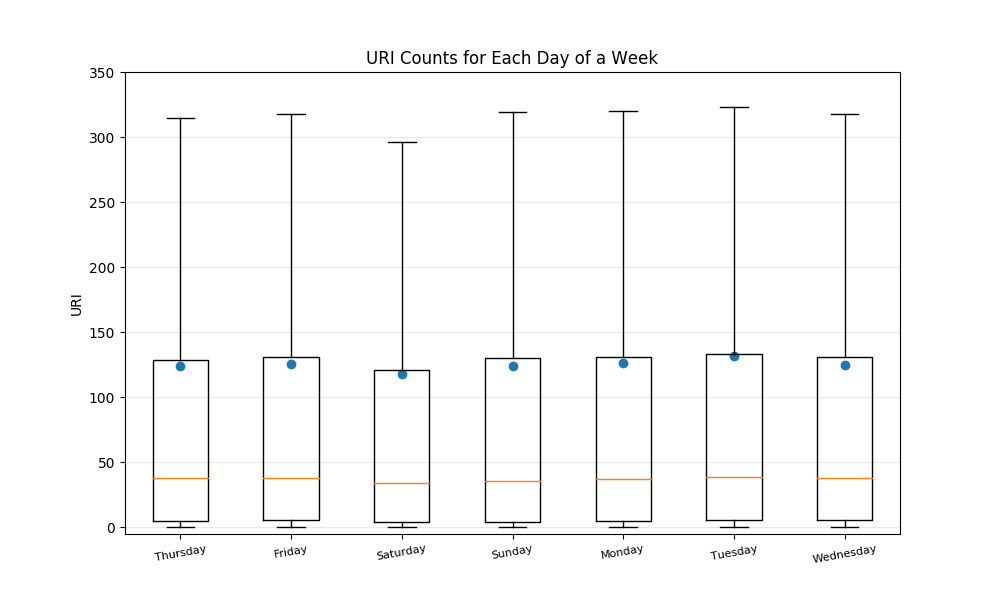

In [45]:
day_data = get_day_arrays('td_uri')
draw_box_plots(bp_day_lbls, day_data, 'URI Counts for Each Day of a Week', 'URI', -5, 350)

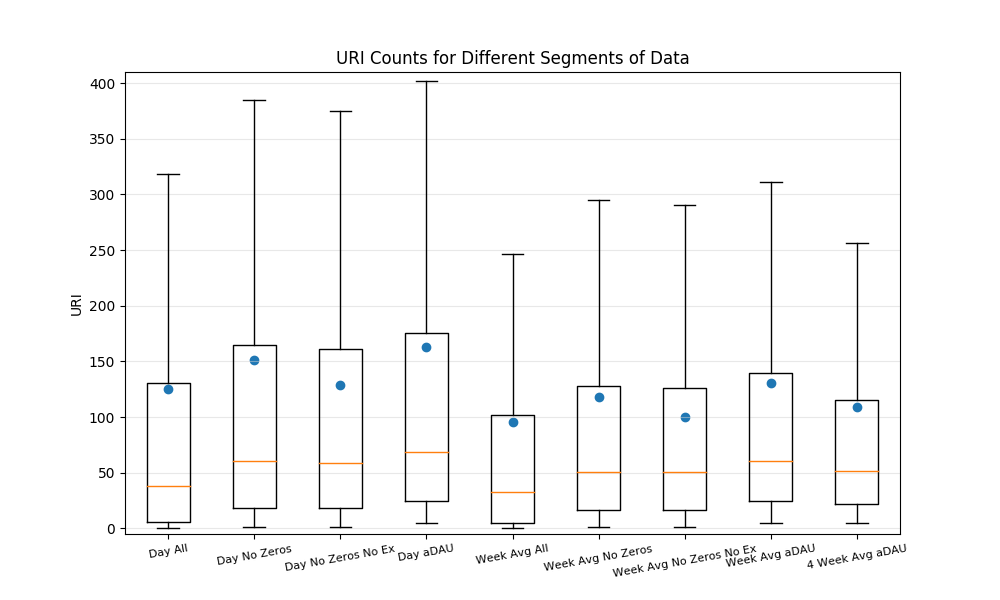

In [46]:
seg_data = get_seg_arrays('td_uri', 'avg_uri')
draw_box_plots(bp_seg_lbls, seg_data, 'URI Counts for Different Segments of Data', 'URI', -5, 410)

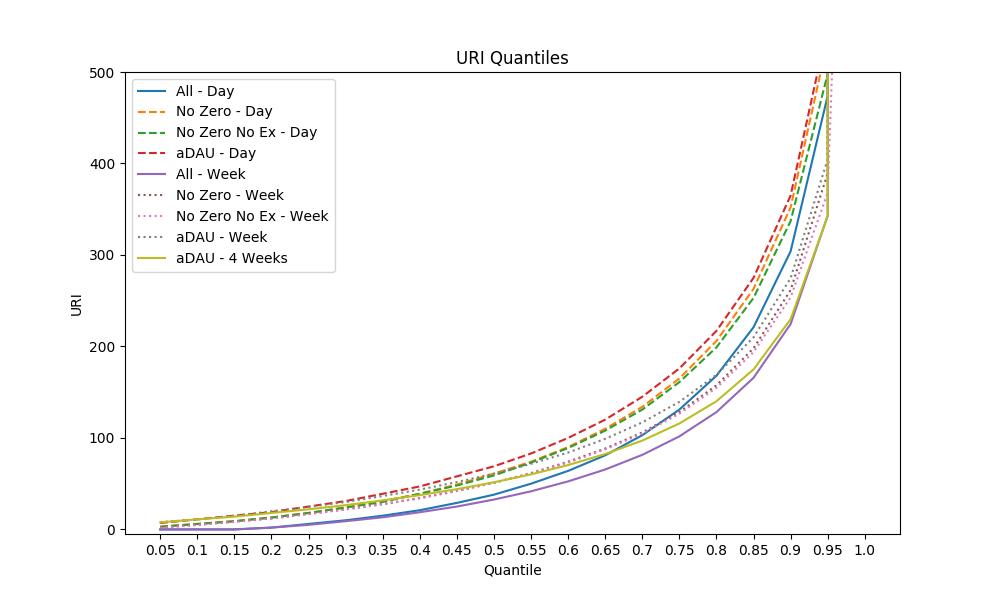

In [47]:
quant_data = get_quant_arrays('td_uri', 'avg_uri')
draw_quantiles(quant_data, 'URI Quantiles', 'URI', -5, 500)

In [48]:
uri_percentiles = get_quant_df('td_uri', 'avg_uri')
display(uri_percentiles)

Percentile,Day All,Day Nz,Day NzNx,Day aDAU,Week All,Week Nz,Week NzNx,Week aDAU,4 Weeks aDAU
50.0,38.00,61.00,59.00,69.00,32.67,51.00,51.00,61.00,51.54
75.0,131.00,165.00,161.00,176.00,101.71,128.25,126.43,139.40,115.81
80.0,168.00,206.00,199.00,217.00,128.25,157.50,154.75,169.00,140.10
90.0,304.00,352.00,337.00,365.00,224.50,261.60,253.57,274.67,229.75
95.0,474.00,534.00,498.00,550.00,343.00,389.40,368.00,404.60,342.60
96.0,536.00,600.00,555.00,616.00,386.57,436.00,407.67,452.43,384.48
97.0,622.00,693.00,629.00,712.00,447.71,502.00,460.00,520.00,443.88
97.5,683.00,757.00,679.00,777.00,489.67,547.20,494.33,567.29,485.00
98.0,761.00,841.00,739.00,864.00,545.00,606.71,536.57,628.57,538.53
99.0,1049.00,1150.00,929.00,1188.00,748.00,828.60,672.00,862.00,743.50


#### Search Counts Ranges and Quantiles

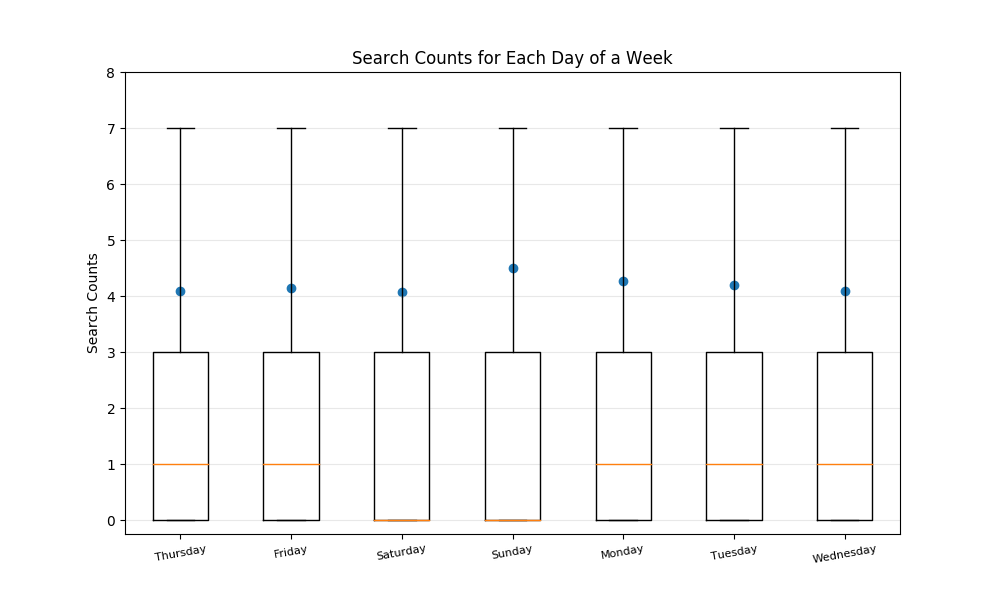

In [50]:
day_data = get_day_arrays('td_search_counts')
draw_box_plots(bp_day_lbls, day_data, 'Search Counts for Each Day of a Week', 'Search Counts', -.25, 1200)

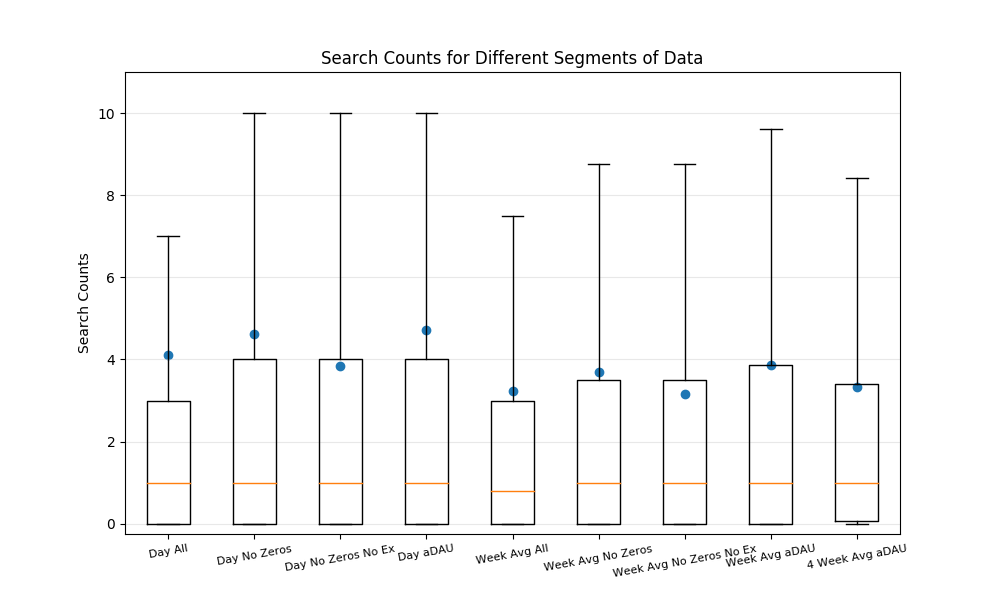

In [51]:
seg_data = get_seg_arrays('td_search_counts', 'avg_search_counts')
draw_box_plots(bp_seg_lbls, seg_data, 'Search Counts for Different Segments of Data', 'Search Counts', -.25, 1200)

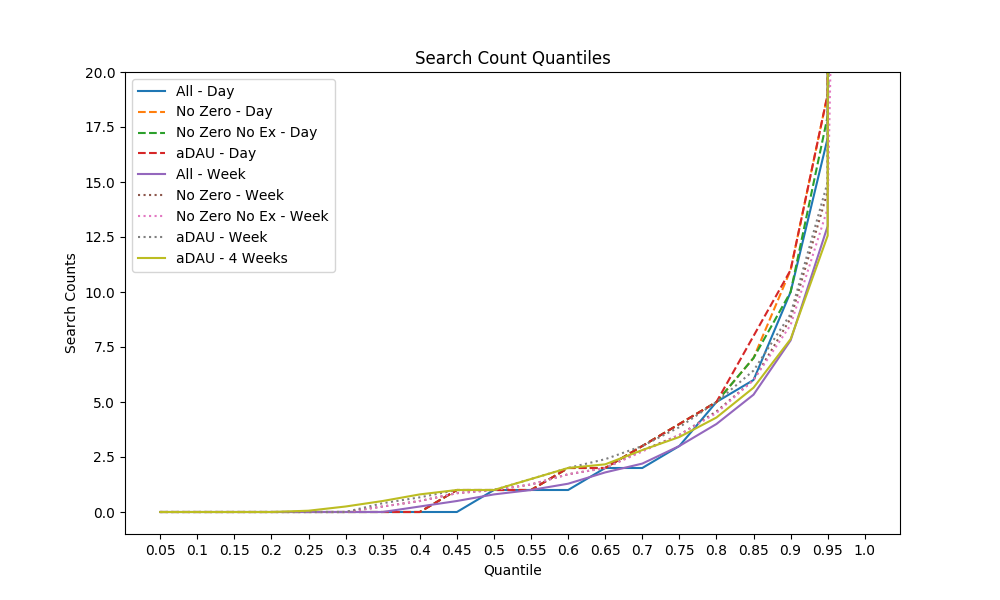

In [52]:
quant_data = get_quant_arrays('td_search_counts', 'avg_search_counts')
draw_quantiles(quant_data, 'Search Count Quantiles', 'Search Counts', -1, 1200)

In [53]:
sc_percentiles = get_quant_df('td_search_counts', 'avg_search_counts')
display(sc_percentiles)

Percentile,Day All,Day Nz,Day NzNx,Day aDAU,Week All,Week Nz,Week NzNx,Week aDAU,4 Weeks aDAU
50.0,1.00,1.00,1.00,1.00,0.80,1.00,1.00,1.00,1.00
75.0,3.00,4.00,4.00,4.00,3.00,3.50,3.50,3.86,3.41
80.0,5.00,5.00,5.00,5.00,4.00,4.57,4.50,5.00,4.29
90.0,10.00,11.00,10.00,11.00,7.80,8.80,8.50,9.00,7.86
95.0,17.00,19.00,18.00,19.00,13.00,14.57,13.80,15.00,12.56
96.0,20.00,22.00,21.00,22.00,15.25,17.00,15.75,17.25,14.45
97.0,25.00,27.00,25.00,27.00,18.43,20.25,18.43,20.67,17.11
97.5,28.00,30.00,27.00,30.00,20.67,22.67,20.20,23.00,19.00
98.0,32.00,35.00,31.00,35.00,23.67,26.00,22.50,26.33,21.59
99.0,49.00,53.00,44.00,53.00,35.20,38.29,30.14,39.00,31.25


#### Active Hours Ranges and Quantiles

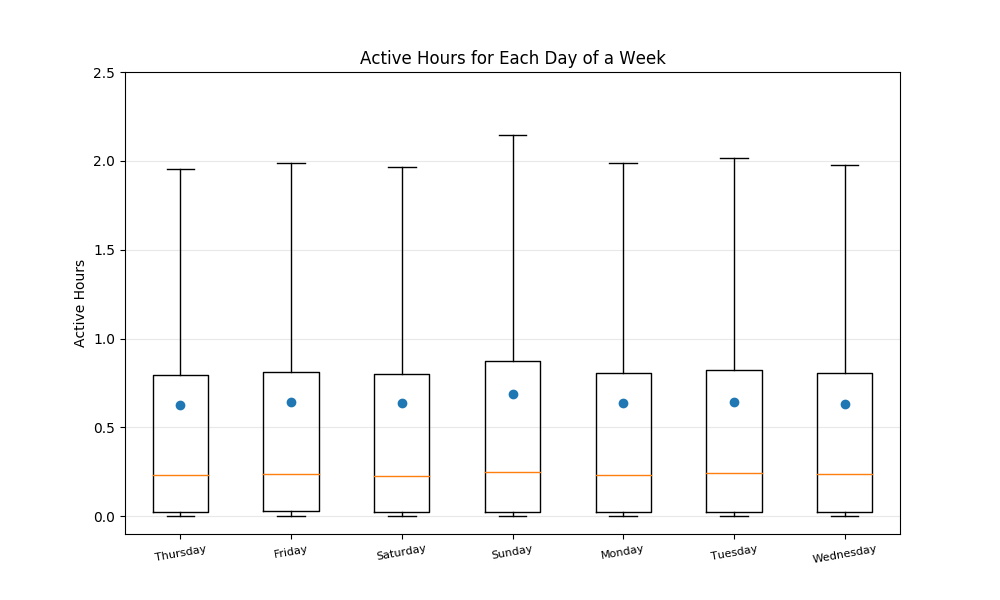

In [55]:
day_data = get_day_arrays('td_active_hours')
draw_box_plots(bp_day_lbls, day_data, 'Active Hours for Each Day of a Week', 'Active Hours', -.1, 2.5)

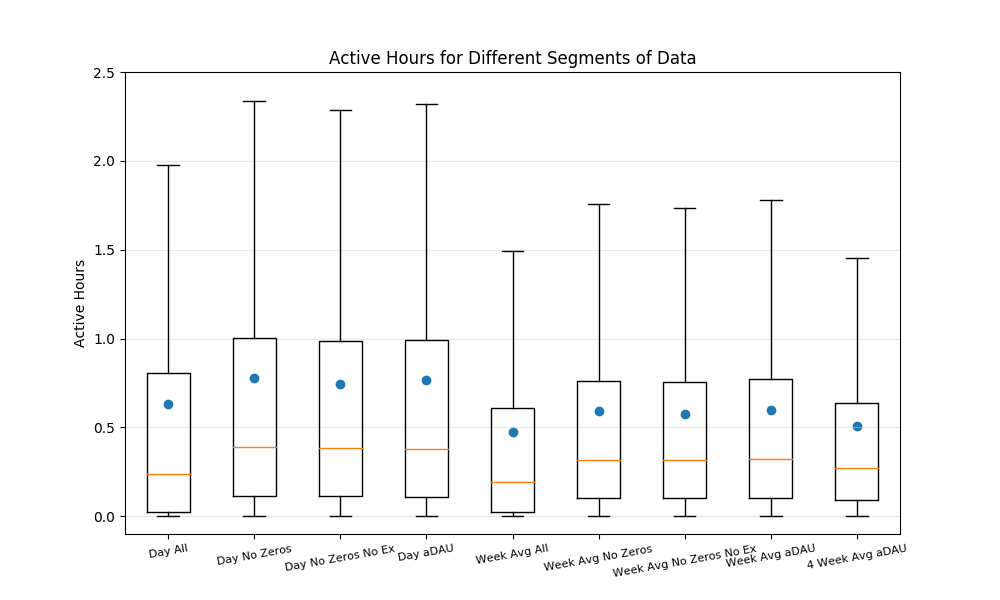

In [56]:
seg_data = get_seg_arrays('td_active_hours', 'avg_active_hours')
draw_box_plots(bp_seg_lbls, seg_data, 'Active Hours for Different Segments of Data', 'Active Hours', -.1, 2.5)

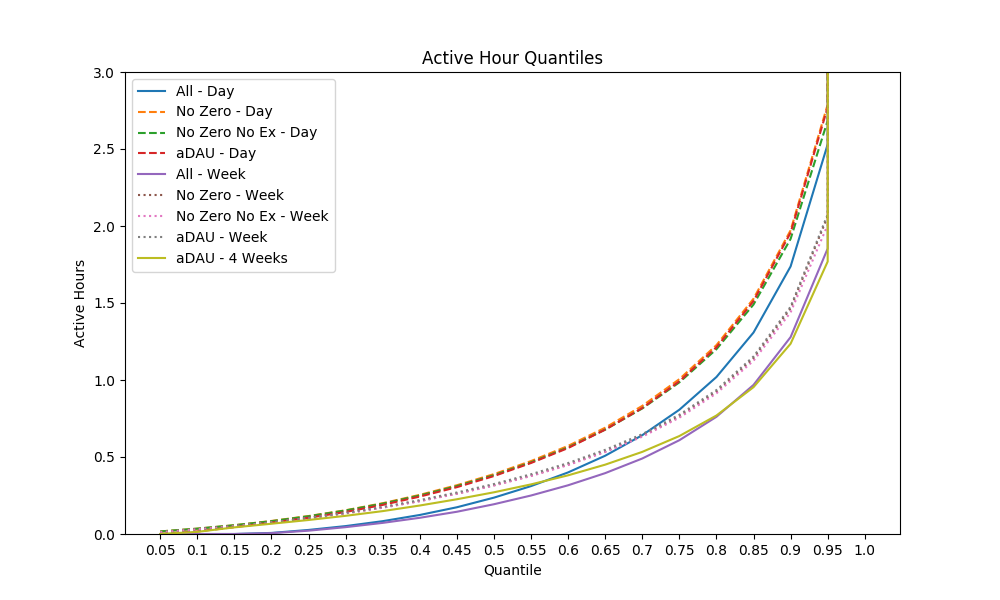

In [57]:
quant_data = get_quant_arrays('td_active_hours', 'avg_active_hours')
draw_quantiles(quant_data, 'Active Hour Quantiles', 'Active Hours', 0, 3)

In [58]:
ah_percentiles = get_quant_df('td_active_hours', 'avg_active_hours')
display(ah_percentiles)

Percentile,Day All,Day Nz,Day NzNx,Day aDAU,Week All,Week Nz,Week NzNx,Week aDAU,4 Weeks aDAU
50.0,0.24,0.39,0.38,0.38,0.19,0.32,0.31,0.32,0.27
75.0,0.81,1.01,0.98,0.99,0.61,0.76,0.76,0.77,0.64
80.0,1.02,1.23,1.20,1.21,0.76,0.92,0.91,0.93,0.77
90.0,1.74,1.97,1.92,1.96,1.28,1.46,1.44,1.48,1.24
95.0,2.53,2.79,2.68,2.77,1.85,2.06,2.01,2.08,1.77
96.0,2.80,3.07,2.94,3.05,2.05,2.27,2.20,2.28,1.95
97.0,3.16,3.44,3.28,3.42,2.31,2.54,2.45,2.55,2.20
97.5,3.40,3.68,3.50,3.66,2.48,2.71,2.61,2.73,2.35
98.0,3.69,3.98,3.77,3.96,2.70,2.94,2.81,2.95,2.56
99.0,4.65,4.97,4.63,4.95,3.40,3.67,3.47,3.69,3.24


#### Correlations

In [60]:
def plot_scatter_line(ax, xarray, xlabel, xlim, yarray, ylabel, ylim):
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, ylim)
    ax.set_xlabel(xlabel)
    ax.set_xlim(0, xlim)
    ax.scatter(xarray, yarray, s=1)
    ax.plot(np.unique(xarray), np.poly1d(np.polyfit(xarray, yarray, 1))(np.unique(xarray)), color='y')
    
    return None

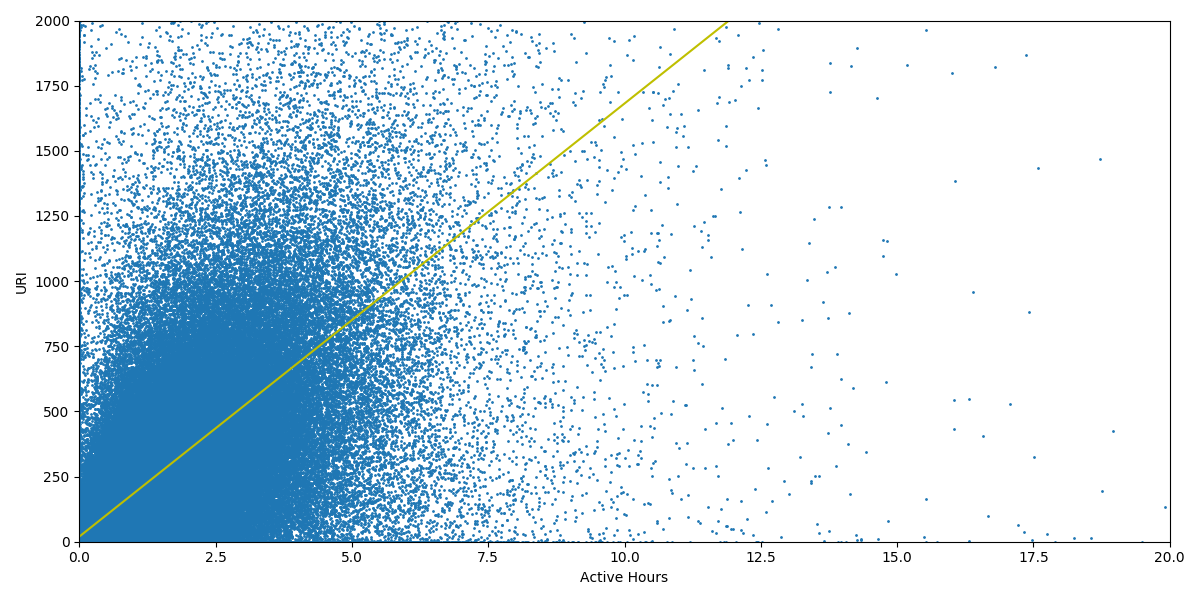

In [61]:
# three scatter plots: uri - sc, uri - ah, sc - ah
active_hrs = np.array(ms_wday.rdd.map(lambda p: p.td_active_hours).collect())
uri = np.array(ms_wday.rdd.map(lambda p: p.td_uri).collect())
search_counts = np.array(ms_wday.rdd.map(lambda p: p.td_search_counts).collect())

plt.gcf().clear()
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

#plot_scatter_line(ax1, search_counts, 'Search Counts', 1200, uri, 'URI', 2000)
plot_scatter_line(ax2, active_hrs, 'Active Hours', 20, uri, 'URI', 2000)
#plot_scatter_line(ax3, active_hrs, 'Active Hours', 20, search_counts, 'Search Counts', 1200)

plt.tight_layout()
display(fig)


In [62]:
print 'Correlation of search counts to uri is', ms_wday.stat.corr('td_search_counts', 'td_uri')
print 'Correlation of active hours to uri is', ms_wday.stat.corr('td_active_hours', 'td_uri')
print 'Correlation of active hours to search counts is', ms_wday.stat.corr('td_active_hours', 'td_search_counts')

Correlation of search counts to uri is 0.121785673003
Correlation of active hours to uri is 0.248319292574
Correlation of active hours to search counts is 0.346716682093

### Proposed heavy user  

The “heavy-half” concept  generally suggests that 80% of the volume of a product is consumed by 20% of its consumers (Twedt 1964)  
https://en.ryte.com/wiki/Heavy_User

In Project Ahab they considered users based on time, intensity (uri) and revenue (search).

3 Heavy User types
* 80th percentile or higher in active hours 
* 80th percentile or higher in uri 
* 80th percentile or higher in search count  
  
Drawbacks to this approach:  
The URI counts do not include private browsing.  
The active hours do not include time watching videos or reading a long article.

The cutoff I've used below is **80th percentile for 1 week average of aDAU**: uri >= 169, active hours >= 0.93 hours

I checked this notebook for two additional sample ids for the same dates and the numbers were very similar.  
For sample id 42 the 80th percentile for 1 week average of aDAU: uri = 169.00, and active hours = 0.93 hours.  
For sample id 35 the 80th percentile for 1 week average of aDAU: uri = 168.71, and active hours = 0.93 hours.   
For sample id 78 the 80th percentile for 1 week average of aDAU: uri = 169.00, and active hours = 0.93 hours. 

I checked this notebook for a week in October and a week in January and the numbers increased in each week.  
For October the 80th percentile for 1 week average of aDAU: uri = 171.00, and active hours = 0.95 hours.  
For January the 80th percentile for 1 week average of aDAU: uri = 172.33, and active hours = 0.97 hours.  
**For this reason, heavy users cutoffs will need to be a methodology and not a fixed number.**

#### Heavy Users - URI  
  
Clients with uri >= 169

In [65]:
# Heavy Users based on uri - one week
heavy_uri = '169'
ms_1week_hu_uri = ms_1week.where('td_uri >= ' +  heavy_uri)
display(ms_1week_hu_uri['submission_date_s3', 'td_uri', 'td_active_hours'].describe())

summary,submission_date_s3,td_uri,td_active_hours
count,1275903,1275903,1275903
mean,2.0180923105917927E7,474.90831591429753,1.8536304581931378
stddev,2.0937514810897406,4568.071580846047,2.4404322001962715
min,20180920,169,0.0
max,20180926,4530092,446.71944444444443


In [66]:
def  print_percents(num_hu_clients, num_avg_hu_clients, num_day_hu_clients, type, description):
    print 'One Week:'
    print '{0:,.0f}'.format(num_all_clients), ' total clients'
    print '  {0:,.0f}'.format(num_hu_clients), 'heavy ' + type + ' clients any day of the week'
    print '   %0.2f'%((num_hu_clients *1.0/num_all_clients) * 100), '% of the clients have heavy ' + description
    print ''
    print 'One Week Average:'
    print '{0:,.0f}'.format(num_all_clients), ' total clients'
    print '  {0:,.0f}'.format(num_avg_hu_clients), 'heavy ' + type + ' clients averaged over the week'
    print '   %0.2f'%((num_avg_hu_clients *1.0/num_all_clients) * 100), '% of the clients have average heavy ' + description
    print 'This is less than 20% because the cutoff was based on aDAU, not all users'
    print ''
    print 'One Day:'
    print '{0:,.0f}'.format(num_wday_clients), ' total clients'
    print '  {0:,.0f}'.format(num_day_hu_clients), ' heavy ' + type + ' clients'
    print '   %0.2f'%((num_day_hu_clients *1.0/num_wday_clients) * 100), '% of the clients have heavy ' + description   
    return None
  

In [67]:
num_huuri_clients = ms_1week_hu_uri.select('client_id').distinct().count()
num_avg_huuri_clients = ms_1week_avg.where('avg_uri >= ' +  heavy_uri).select('client_id').distinct().count()
wday_huuri_clients = ms_1week_hu_uri.where(wday_cond)
num_wday_huuri_clients = wday_huuri_clients.count()

print_percents(num_huuri_clients, num_avg_huuri_clients, num_wday_huuri_clients, 'URI', 'URI counts')

One Week:
1,851,293 total clients
 514,621 heavy URI clients any day of the week
 27.80 % of the clients have heavy URI counts

One Week Average:
1,851,293 total clients
 271,431 heavy URI clients averaged over the week
 14.66 % of the clients have average heavy URI counts
This is less than 20% because the cutoff was based on aDAU, not all users

One Day:
1,040,177 total clients
 207,344 heavy URI clients
 19.93 % of the clients have heavy URI counts

In [68]:
# Cut off these records at 7000 URI to generate a nice graph
ex_uri = '7000'
ms_1week_xhuuri = ms_1week.where('td_uri > ' + ex_uri)
print ms_1week_xhuuri.count(), 'records above 7000 uri for', ms_1week_xhuuri.select('client_id').distinct().count(), 'clients'
print 'The max value for uri is', '{0:,.0f}'.format(ms_1week_xhuuri.agg({'td_uri' : 'max'}).collect()[0][0])

2549 records above 7000 uri for 1405 clients
The max value for uri is 4,530,092

In [69]:
# Look at the week's heavy user records
display(ms_1week.where('td_uri >= ' + heavy_uri + ' and td_uri <= ' + ex_uri).sort('client_id', 'submission_date_s3').select(ms_1week_cols))

submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,update_enabled,update_auto_download,timezone_offset,vendor,is_default_browser,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_configured,sync_count_desktop,sync_count_mobile,sample_id
20180921,237,996,1.3833333333333333,29.6575,3,11.0,18,1,16,16337,null,release,Windows_NT,6.1,7601,2014,null,5,20180830143136,62.0,release,true,true,180,Mozilla,false,google,0,3.0,7231.0,8,0,RO,Târgu Mureş,MS,en-GB,null,0,0,42
20180924,209,815,1.1319444444444444,3.8247222222222224,2,11.0,20,1,14,16337,null,release,Windows_NT,6.1,7601,2014,null,3,20180830143136,62.0,release,true,true,180,Mozilla,false,google,0,3.0,7295.0,22,0,RO,Târgu Mureş,MS,en-GB,null,0,0,42
20180925,479,1315,1.8263888888888888,6.316666666666666,2,11.0,18,1,19,16337,20180830143136,release,Windows_NT,6.1,7601,2014,null,2,20180920131237,62.0.2,release,true,true,180,Mozilla,false,google,0,3.0,7436.0,17,0,RO,Târgu Mureş,MS,en-GB,null,0,0,42
20180924,191,697,0.9680555555555554,126.27444444444446,0,10.0,5,3,4,17521,null,release,Windows_NT,6.3,9600,2014,null,3,20180830143136,62.0,release,true,true,-360,Mozilla,false,google,0,8.0,304.0,21,5,MX,Chihuahua City,CHH,es-MX,null,0,0,42
20180922,536,957,1.3291666666666666,2.533611111111111,2,10.0,31,10,15,17145,null,release,Windows_NT,6.1,7601,2014,null,4,20180830143136,62.0,release,true,true,480,Mozilla,true,google,0,44.0,4610.0,203,48,TW,??,TAO,zh-TW,null,3,0,42
20180923,3390,1534,2.1305555555555555,5.141388888888889,1,10.0,39,16,35,17145,null,release,Windows_NT,6.1,7601,2014,null,2,20180830143136,62.0,release,true,true,480,Mozilla,true,google,0,44.0,6208.0,312,49,TW,??,TAO,zh-TW,null,1,0,42
20180923,778,2322,3.225,23.39138888888889,0,13.0,16,1,37,17692,null,release,Windows_NT,10.0,17134,2018,null,1,20180830143136,62.0,release,true,true,120,Mozilla,true,google,0,22.0,23326.0,24,0,ES,Santander,CB,es-ES,null,0,0,42
20180924,200,580,0.8055555555555556,2.246111111111111,0,13.0,5,1,5,17692,null,release,Windows_NT,10.0,17134,2018,null,1,20180830143136,62.0,release,true,true,120,Mozilla,true,google,0,22.0,23783.0,2,0,ES,Santander,CB,es-ES,null,0,0,42
20180925,753,1590,2.2083333333333335,29.28972222222222,1,11.0,14,2,42,17692,20180830143136,release,Windows_NT,10.0,17134,2018,null,2,20180920131237,62.0.2,release,true,true,120,Mozilla,true,google,0,25.0,24263.0,17,2,ES,Santander,CB,es-ES,null,0,0,42
20180926,1063,1170,1.625,34.42111111111111,1,13.0,21,2,12,17692,null,release,Windows_NT,10.0,17134,2018,null,2,20180920131237,62.0.2,release,true,true,120,Mozilla,true,google,0,0.0,0.0,27,2,ES,Santander,CB,es-ES,null,0,0,42


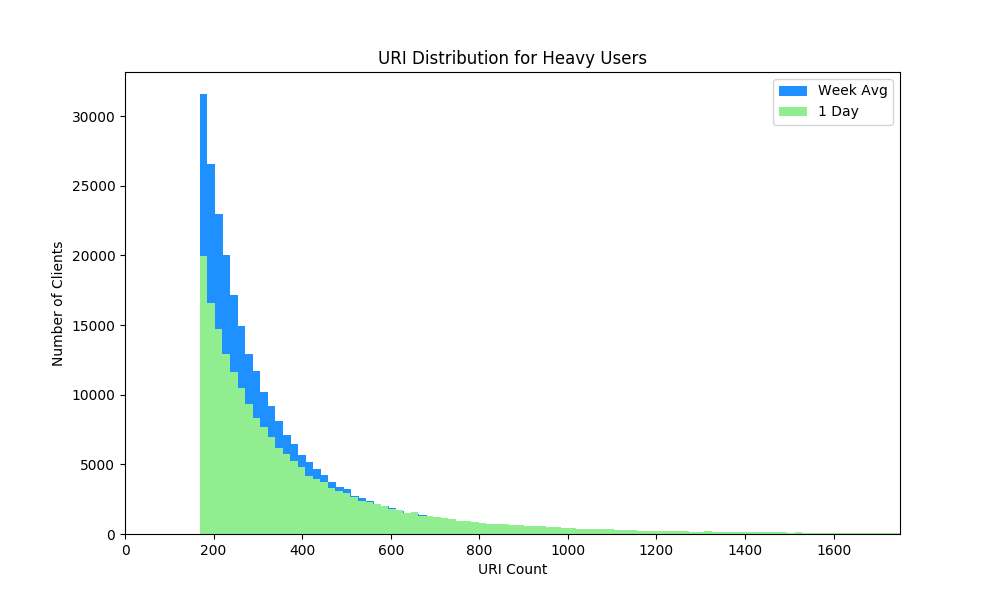

In [70]:
# Generate histogram 
ms_1week_avg_huuri = ms_1week_avg.where('avg_uri >= ' + heavy_uri + ' and avg_uri <= ' + ex_uri)
huuri_avg_arry = array(ms_1week_avg_huuri.select('avg_uri').rdd.flatMap(lambda x: x).collect())

ms_week_huuri_max = ms_1week.where('td_uri >= ' + heavy_uri + ' and td_uri <= ' + ex_uri) \
          .groupby('client_id').agg(F.max('td_uri')).withColumnRenamed('max(td_uri)', 'max_td_uri').sort('client_id')
huuri_max_arry = array(ms_week_huuri_max.select('max_td_uri').rdd.flatMap(lambda x: x).collect())

ms_wday_huuri = ms_wday.where('td_uri >= ' + heavy_uri + ' and td_uri <= ' + ex_uri)
huuri_day_arry = array(ms_wday_huuri.select('td_uri').rdd.flatMap(lambda x: x).collect())

num_bins = 400
plt.gcf().clear()
fig, ax = plt.subplots(figsize=(10,6))

# the histogram of the data
#n, bins, patches = ax.hist(huuri_max_arry, num_bins, label = 'Week Max', color = 'slateblue')
ax.hist(huuri_avg_arry, num_bins, label = 'Week Avg', color = 'dodgerblue')
ax.hist(huuri_day_arry, num_bins, label = '1 Day', color = 'lightgreen')

ax.set_xlabel('URI Count')
ax.set_ylabel('Number of Clients')
ax.set_title(r'URI Distribution for Heavy Users')
ax.set_xlim(0, 1750)
ax.legend(loc='best')

display(fig)

#### Heavy Users - Search Count

In [72]:
# Heavy Users based on search count - one week
#ms_1week_hu_sc = ms_1week.where('td_search_counts >= ' + heavy_sc)
#display(ms_1week_hu_sc['submission_date_s3', 'td_uri', 'td_active_hours', 'td_search_counts'].describe())

In [73]:
#num_husc_clients = ms_1week_hu_sc.select('client_id').distinct().count()
#num_avg_husc_clients = ms_1week_avg.where('avg_search_counts >= ' +  heavy_sc).select('client_id').distinct().count()
#wday_husc_clients = ms_1week_hu_sc.where(wday_cond)
#num_wday_husc_clients = wday_husc_clients.count()

#print_percents(num_husc_clients, num_avg_husc_clients, num_wday_husc_clients, 'search count', 'search counts')

In [74]:
# Cut off these records at 1000 search counts to generate a nice graph
#ms_1week_xhusc = ms_1week.where('td_search_counts > ' + ex_sc)
#print ms_1week_xhusc.count(), 'records above 1000 search counts for', ms_1week_xhusc.select('client_id').distinct().count(), 'clients'
#print 'The max value for search counts is', '{0:,.0f}'.format(ms_1week_xhusc.agg({'td_search_counts' : 'max'}).collect()[0][0])

In [75]:
# Generate histogram
#ms_1week_avg_husc = ms_1week_avg.where('avg_search_counts >= ' + heavy_sc + ' and avg_search_counts <= ' + ex_sc)
#husc_avg_arry = array(ms_1week_avg_husc.select('avg_search_counts').rdd.flatMap(lambda x: x).collect())
#ms_week_husc_max = ms_1week.where('td_search_counts >= ' + heavy_sc + ' and td_search_counts <= ' + ex_sc) \
#          .groupby('client_id').agg(F.max('td_search_counts')).withColumnRenamed('max(td_search_counts)', 'max_td_search_counts') \
#          .sort('client_id')
#husc_max_arry = array(ms_week_husc_max.select('max_td_search_counts').rdd.flatMap(lambda x: x).collect())
#ms_wday_husc = ms_wday.where('td_search_counts >= ' + heavy_sc + ' and td_search_counts <= ' + ex_sc)
#husc_day_arry = array(ms_wday_husc.select('td_search_counts').rdd.flatMap(lambda x: x).collect())
#
#num_bins = 1000
#plt.gcf().clear()
#fig, ax = plt.subplots(figsize=(10,6))
#
## the histogram of the data
##ax.hist(husc_max_arry, num_bins, label = 'Week Max', color = 'slateblue')
#ax.hist(husc_avg_arry, num_bins, label = 'Week Avg', color = 'dodgerblue')
#ax.hist(husc_day_arry, num_bins, label = '1 Day', color = 'lightgreen')
#
#ax.set_xlabel('Search Count')
#ax.set_ylabel('Number of Clients')
#ax.set_title(r'Search Count Distribution for Heavy Users')
#ax.legend(loc='best')
#
#display(fig)

#### Heavy Users - Active Hours  
  
Clients with active hours >= 0.93 hours

In [77]:
# Heavy Users based on active hours - one week
heavy_ah = '0.93'
ms_1week_hu_ah = ms_1week.where('td_active_hours >= ' + heavy_ah)
display(ms_1week_hu_ah['submission_date_s3', 'td_uri', 'td_active_hours'].describe())

summary,submission_date_s3,td_uri,td_active_hours
count,1426726,1426726,1426726
mean,2.018092309694994E7,358.12155382322885,2.113977851310545
stddev,2.0792608422298597,1757.6349865703012,2.3067160983376267
min,20180920,0,0.9305555555555554
max,20180926,807495,446.7194444444445


In [78]:
num_huah_clients = ms_1week_hu_ah.select('client_id').distinct().count()
num_avg_huah_clients = ms_1week_avg.where('avg_active_hours >= ' +  heavy_ah).select('client_id').distinct().count()
wday_huah_clients = ms_1week_hu_ah.where(wday_cond)
num_wday_huah_clients = wday_huah_clients.count()

print_percents(num_huah_clients, num_avg_huah_clients, num_wday_huah_clients, 'active hour', 'active hours')

One Week:
1,851,293 total clients
 538,262 heavy active hour clients any day of the week
 29.07 % of the clients have heavy active hours

One Week Average:
1,851,293 total clients
 292,278 heavy active hour clients averaged over the week
 15.79 % of the clients have average heavy active hours
This is less than 20% because the cutoff was based on aDAU, not all users

One Day:
1,040,177 total clients
 228,262 heavy active hour clients
 21.94 % of the clients have heavy active hours

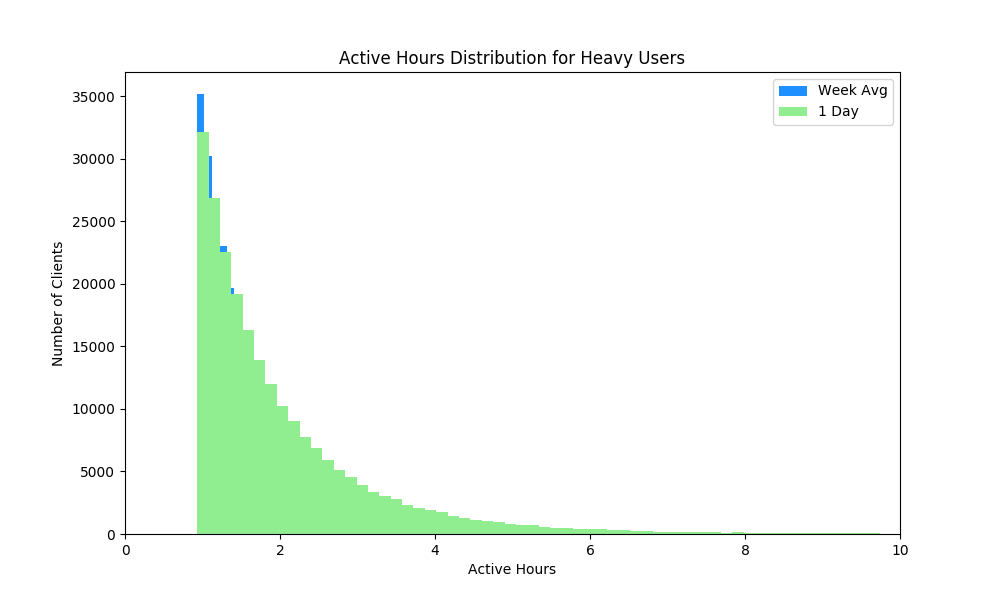

In [79]:
# Histogram of active hours in heavy range
ms_1week_avg_huah = ms_1week_avg.where('avg_active_hours >= ' + heavy_ah )
huah_avg_arry = array(ms_1week_avg_huah.select('avg_active_hours').rdd.flatMap(lambda x: x).collect())
ms_week_huah_max = ms_1week.where('td_active_hours >= ' + heavy_ah) \
          .groupby('client_id').agg(F.max('td_active_hours')).withColumnRenamed('max(td_active_hours)', 'max_td_active_hours') \
          .sort('client_id')
huah_max_arry = array(ms_week_huah_max.select('max_td_active_hours').rdd.flatMap(lambda x: x).collect())
ms_wday_huah = ms_wday.where('td_active_hours >= ' + heavy_ah)
huah_day_arry = array(ms_wday_huah.select('td_active_hours').rdd.flatMap(lambda x: x).collect())

num_bins = 3000
plt.gcf().clear()
fig, ax = plt.subplots(figsize=(10,6))

# the histogram of the data
#ax.hist(huah_max_arry, num_bins, label = 'Week Max', color = 'slateblue')
ax.hist(huah_avg_arry, num_bins, label = 'Week Avg', color = 'dodgerblue')
ax.hist(huah_day_arry, num_bins, label = '1 Day', color = 'lightgreen')

ax.set_xlabel('Active Hours')
ax.set_ylabel('Number of Clients')
ax.set_title(r'Active Hours Distribution for Heavy Users')
ax.set_xlim(0, 10)
ax.legend(loc='best')

display(fig)

#### Heavy Users - Any of the 3 variables

Clients with uri >= 169, or active hours >= 0.93 hours

In [81]:
# Heavy Users, 80th percentile, 1 week aDAU
ms_1week_hu = ms_1week.where('td_uri >= ' +  heavy_uri + ' or td_active_hours >= ' + heavy_ah)
display(ms_1week_hu.select(ms_1week_cols).describe())

summary,submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,timezone_offset,vendor,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_count_desktop,sync_count_mobile,sample_id
count,1751441,1751441,1751441,1751441,1751441,1751441,1751441,1751441,1751441,1751441,1751441,176825,1751441,1751441,1751441,1751441,1751441,168720,1751441,1751441,1751006,1751441,1751441,1751441,1750557,1751441,1751441,1751441,1751441,1751441,1750233,1750233,1613972,1751441,1751441,1751441,1751441
mean,2.0180923099851493E7,368.03862533765056,1304.7092194370236,1.8120961381069771,16.18980413382148,4.155551914109582,10.636362758969783,11.869184288822746,2.065385588209937,11.657676735899182,17024.478536816256,2.0180331503881836E13,null,null,7.902477410552703,10762.39481204334,1829.446735573736,65811.66451612904,5.290785701602281,2.0180552610186656E13,61.878357779103496,null,72.72296240638423,null,null,0.13528859950178168,154.67660396723997,16572.195295639358,44.94370749571353,5.5468588436607345,null,null,27.165359580527053,null,0.5988063543105363,0.10729336586273817,42.0
stddev,2.0873700920183498,3902.9595743885243,1570.1800786422164,2.180805664780856,3367.694364852289,17.93840988025279,2.5167350736349374,63.90052047113671,2.183423804020037,10.92118219682595,14029.823814364678,4.806140648011686E10,null,null,1.9640245591867163,102564.65904244846,584.6942797258198,86734.55177498475,19.209786221909344,1.853326661619691E9,0.9243783896873069,null,256.8830195742028,null,null,10.607843390212857,1798.7271366748948,31423.98944495967,325.0905305160292,36.216441557478845,null,null,23.80579807045848,null,5.40267570966292,3.192212821815541,0.0
min,20180920,0,0,0.0,0.011111111111111112,0,0.0,0,0,0,-134774,20130618035212,Other,Darwin,10.0,0,0,,1,20130910201120,46.0,EDS Group,-720,Firefox,1und1-suche,0,0.0,0.0,0,0,AD,'Ain Deheb,00,ach,0,0,42
max,20180926,4530092,321638,446.7194444444443,3953868.0052777776,7479,78.0,14574,581,100,2932884,20180925220052,release,Windows_NT,6.3,67766446,2106,yandex-ru-mz,7625,20180926142055,64.0a1,updates_disabled,1260,Mozilla,zoznam-sk,8168,338257.0,2743033.0,328760,17035,ZW,Žilina,ZZ,zh-TW,4083,2722,42


In [82]:
# Heavy User sample days
display(ms_1week_hu['submission_date_s3', 'td_uri', 'td_active_hours'])

submission_date_s3,td_uri,td_active_hours
20180922,171,1.6236111111111111
20180920,0,1.5791666666666666
20180924,238,0.0
20180926,5516,24.595833333333328
20180921,174,1.0416666666666667
20180920,84,9.105555555555556
20180921,212,0.8833333333333333
20180926,757,2.283333333333333
20180921,0,1.2208333333333334
20180921,0,1.1291666666666667


In [83]:
num_hu_clients = ms_1week_hu.select('client_id').distinct().count()
num_avg_hu_clients = ms_1week_avg \
    .where('avg_uri >= ' +  heavy_uri + ' or avg_active_hours >= ' + heavy_ah) \
    .select('client_id').distinct().count()
num_wday_hu_clients = ms_1week_hu.where(wday_cond).count()

print_percents(num_hu_clients, num_avg_hu_clients, num_wday_hu_clients, 'use', 'usage in any category')

One Week:
1,851,293 total clients
 653,022 heavy use clients any day of the week
 35.27 % of the clients have heavy usage in any category

One Week Average:
1,851,293 total clients
 373,810 heavy use clients averaged over the week
 20.19 % of the clients have average heavy usage in any category
This is less than 20% because the cutoff was based on aDAU, not all users

One Day:
1,040,177 total clients
 282,666 heavy use clients
 27.17 % of the clients have heavy usage in any category

Correlation of Heavy User Types

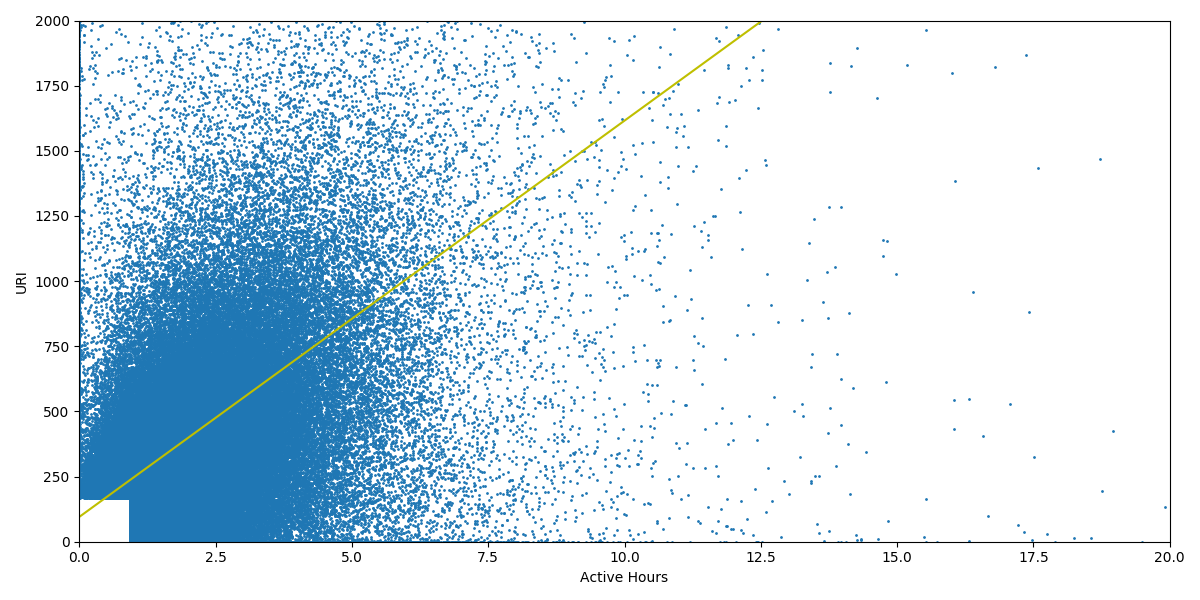

In [85]:
# three scatter plots: uri - sc, uri - ah, sc - ah
wday_hu = ms_1week_hu.where(wday_cond)
active_hrs = np.array(wday_hu.rdd.map(lambda p: p.td_active_hours).collect())
uri = np.array(wday_hu.rdd.map(lambda p: p.td_uri).collect())
search_counts = np.array(wday_hu.rdd.map(lambda p: p.td_search_counts).collect())

plt.gcf().clear()
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

#plot_scatter_line(ax1, search_counts, 'Search Counts', 1200, uri, 'URI', 2000)
plot_scatter_line(ax2, active_hrs, 'Active Hours', 20, uri, 'URI', 2000)
#plot_scatter_line(ax3, active_hrs, 'Active Hours', 20, search_counts, 'Search Counts', 1200)

plt.tight_layout()
display(fig)

In [86]:
print 'Correlation of search counts to uri is', wday_hu.stat.corr('td_search_counts', 'td_uri')
print 'Correlation of active hours to uri is', wday_hu.stat.corr('td_active_hours', 'td_uri')
print 'Correlation of active hours to search counts is', wday_hu.stat.corr('td_active_hours', 'td_search_counts')

Correlation of search counts to uri is 0.109556065293
Correlation of active hours to uri is 0.195310881635
Correlation of active hours to search counts is 0.347698684203

In [87]:
# Get number of clients who are in both types of heavy users
#num_uri_sc = wday_huuri_clients.join(wday_husc_clients, 'client_id', 'inner').count()
num_uri_ah = wday_huuri_clients.join(wday_huah_clients, 'client_id', 'inner').count()
#num_sc_ah = wday_husc_clients.join(wday_huah_clients, 'client_id', 'inner').count()

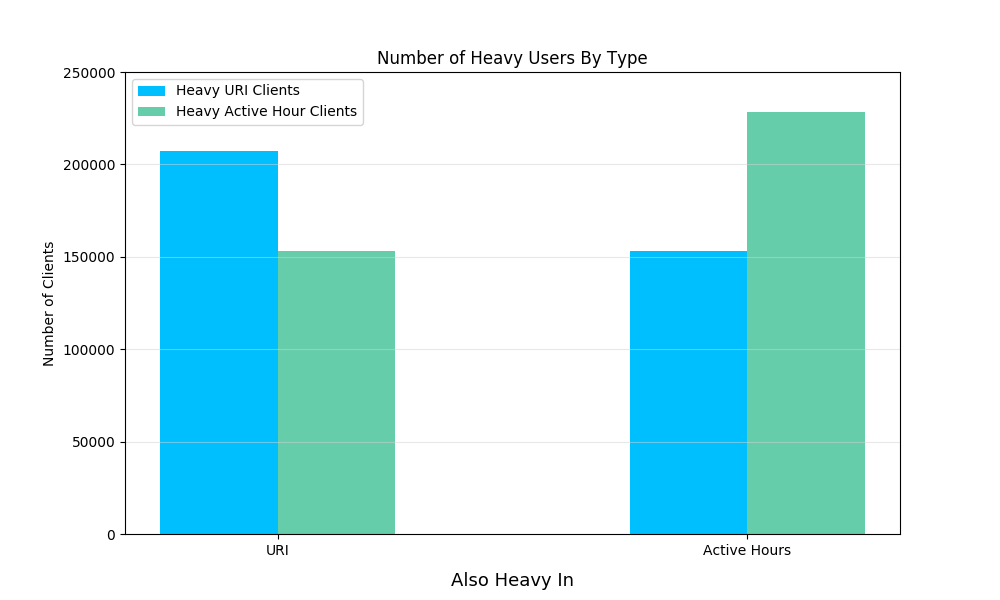

In [88]:
# bar chart with three bars - all URI heavy users, URI heavy users also SC HU, URI heavy users also AH heavy users
# array for x axis
type_hu = ['URI', 'Active Hours']
# array for y axis, number of clients
num_clients_huuri = [num_wday_huuri_clients, num_uri_ah]
#num_clients_husc = [num_uri_sc, num_wday_husc_clients, num_sc_ah]
num_clients_huah = [num_uri_ah, num_wday_huah_clients]

width = 0.25
plt.gcf().clear()
fig, ax = plt.subplots(figsize=(10,6))

# the bar chart of the data
xticks = array(list(range(0, len(type_hu))))
ax.bar(xticks - width/2, num_clients_huuri, width, label = 'Heavy URI Clients', color = 'deepskyblue')
#ax.bar(xticks, num_clients_husc, width, label = 'Heavy Search Count Clients', color = 'lightsalmon')
ax.bar(xticks + width/2, num_clients_huah, width, label = 'Heavy Active Hour Clients', color = 'mediumaquamarine')

ax.set_xticks(xticks)
ax.set_xticklabels(type_hu)
ax.set_ylim(0, 250000)
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)  
#ax.set_xlabel('Day of the Week')
ax.set_ylabel('Number of Clients')
ax.set_xlabel('Also Heavy In', fontsize=13)
ax.xaxis.labelpad = 10 
ax.set_title(r'Number of Heavy Users By Type')
ax.legend(loc='best')

display(fig)

Heavy Users - All of the 3 variables

Clients with uri >= 169 and active hours >= 0.93 hours

In [90]:
# Heavy Users, 80th percentile, 1 week aDAU
ms_1week_allhu = ms_1week.where('td_uri >= ' +  heavy_uri + ' and td_active_hours >= ' + heavy_ah)
display(ms_1week_allhu.select(ms_1week_cols).describe())

summary,submission_date_s3,td_uri,td_active_ticks,td_active_hours,td_subsession_hours,sessions_started_on_this_day,active_addons_count_mean,tab_count_max,window_count_max,domains_count_max,profile_creation_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,distribution_id,pings_aggregated_by_this_row,app_build_id,app_display_version,update_channel,timezone_offset,vendor,default_search_engine,devtools_toolbox_opened_count_sum,places_bookmarks_count_mean,places_pages_count_mean,td_tab_event_count,td_window_event_count,country,city,geo_subdivision1,locale,sync_count_desktop,sync_count_mobile,sample_id
count,951188,951188,951188,951188,951188,951188,951188,951188,951188,951188,951188,98984,951188,951188,951188,951188,951188,89672,951188,951188,950954,951188,951188,951188,950729,951188,951188,951188,951188,951188,950594,950594,879417,951188,951188,951188,951188
mean,2.0180923103636716E7,496.516292257682,1670.8422046956018,2.3206141731883343,17.6986439116137,4.550426414126335,10.981971045975829,14.352062893981001,2.1973868467642568,15.357103958418314,17039.817346307984,2.0180543157355484E13,null,null,8.048653900121785,11063.800580957708,1813.0240814644424,1.0133333333333332,5.888001110190625,2.0180729877048395E13,61.929093155099146,null,72.00753058280803,null,null,0.15971816297093738,186.69010713685674,21028.87123053374,58.19793458285849,6.812490275318864,null,null,26.981699006184805,null,0.744834880170902,0.13407654427936433,42.0
stddev,2.0838116452329065,2138.835958756099,1917.582728411348,2.6633093450157586,4055.4022988173483,23.323862712597176,2.312921646903417,76.68322844821948,2.3948515846542127,12.060514179160407,12466.110438929194,2.2941476045685077E9,null,null,1.9355933546615343,5685.366917411597,607.3992399923981,0.05163977794943221,25.056511492947955,1.1718716193100274E9,0.613882481554934,null,258.0442088300372,null,null,4.0209200467178885,1943.68173637503,33925.049109399995,191.10996845429554,36.675794185115876,null,null,23.730812407343553,null,3.483689111626574,1.2745520117136249,0.0
min,20180920,169,670,0.9305555555555554,0.9480555555555557,0,0.0,0,0,0,-134770,20130618035212,Other,Darwin,10.0,0,0,,1,20130910201120,46.0,ESR,-720,Mozilla,1und1-suche,0,0.0,0.0,0,0,AD,'Ain Deheb,00,af,0,0,42
max,20180926,807495,321638,446.7194444444444,3953868.0052777776,7479,78.0,14574,581,100,2932884,20180925220052,release,Windows_NT,6.3,18242,2106,yandex-ru-mz,7625,20180926142055,64.0a1,updates_disabled,1260,Mozilla,zoznam-sk,2219,289441.0,780780.0,45206,9218,ZW,Žilina,ZP,zh-TW,480,228,42


In [91]:
num_allhu_clients = ms_1week_allhu.select('client_id').distinct().count()
num_avg_allhu_clients = ms_1week_avg \
        .where('avg_uri >= ' +  heavy_uri + ' and avg_active_hours >= ' + heavy_ah) \
        .select('client_id').distinct().count()
num_wday_allhu_clients = ms_1week_allhu.where(wday_cond).count()

print_percents(num_allhu_clients, num_avg_allhu_clients, num_wday_allhu_clients, 'use', 'usage in all categories')

One Week:
1,851,293 total clients
 392,510 heavy use clients any day of the week
 21.20 % of the clients have heavy usage in all categories

One Week Average:
1,851,293 total clients
 189,897 heavy use clients averaged over the week
 10.26 % of the clients have average heavy usage in all categories
This is less than 20% because the cutoff was based on aDAU, not all users

One Day:
1,040,177 total clients
 152,940 heavy use clients
 14.70 % of the clients have heavy usage in all categories

#### Heavy Users over Time

Heavy Users over time can be seen in this notebook: <a href="https://dbc-caf9527b-e073.cloud.databricks.com/#notebook/81242/command/81330">Heavy Users over Time</a>

#### Attributes of Heavy Users

The attributes of Heavy Users can be seen in this notebook: <a href="https://dbc-caf9527b-e073.cloud.databricks.com/#notebook/73994/command/76992">Heavy User Attributes</a>